In [645]:
import pandas as pd
import plotnine as pn
import numpy as np

from tqdm import tqdm

In [646]:
df_all = pd.read_csv("../../analysis_data/all_data.csv")
df_all

density  edginess  references  citations_per_year  is_center  \
0       38.076275  0.721620          88           61.625000      False   
1       41.553209  0.708944          69            8.200000      False   
2       30.062907  0.686039         179            0.000000      False   
3       39.494263  0.681023          55            3.000000      False   
4       43.866830  0.697031          78           13.888889      False   
...           ...       ...         ...                 ...        ...   
106150  48.730838  0.658585          41            3.500000      False   
106151  25.107589  0.721374          38            3.200000      False   
106152  41.647954  0.646499          11            1.529412      False   
106153  35.738649  0.708053          15            2.384615      False   
106154  31.749805  0.670620           7            0.000000      False   

                                      identifier  year librarian vectorizer  \
0       1d4e43c1be145f6711ec00af900a8658d82623a0  2012        S2    SciBERT   
1       16e772e28b3470cb0050328c6e5a500882ff15ae  2015        S2    SciBERT   
2       0bc5bf8a556f158b1bdaada28ce9cbd28c5d55a4  2017        S2    SciBERT   
3       35d7b77f2a6436124346d80aabc4bd66d5e0bd8b  2017        S2    SciBERT   
4       3dddd8f2734680c584e7a60069e38e58a68d54e6  2011        S2    SciBERT   
...                                          ...   ...       ...        ...   
106150  806f77ba7bdf8a3b80cb859fb5f33f57c1d85d24  2018        S2    SciBERT   
106151  f40707d1165c22e185c25e6837977177ee380f2c  2015        S2    SciBERT   
106152  10636ee16779a7521001651164acb5c192d4ad7b  2003        S2    SciBERT   
106153  a229f829e0a5362d00e63781f687f40ede991635  2007        S2    SciBERT   
106154  8f7f47c0acd81752039abad380df57cf39591506  2012        S2    SciBERT   

                                center fields_of_study_0  
0       hafenLowredshiftLymanLimit2017           Physics  
1       hafenLowredshiftLymanLimit2017           Physics  
2       hafenLowredshiftLymanLimit2017           Physics  
3       hafenLowredshiftLymanLimit2017           Physics  
4       hafenLowredshiftLymanLimit2017           Physics  
...                                ...               ...  
106150                       Andre2018       Mathematics  
106151                       Andre2018       Mathematics  
106152                       Andre2018       Mathematics  
106153                       Andre2018       Mathematics  
106154                       Andre2018       Mathematics  

[106155 rows x 11 columns]

In [647]:
# df_all = df_all[df_all["year"] == 2018]

In [648]:

def entropy_estimator(observations: np.ndarray, num_bins: int = 10, bins = range(10)) -> float:
    """Estimate the entropy of a vector of observations by binning the values. Since we typically only look at cpy in the range [0,10], we simply assign 1 bin for each value in this range."""

    if not observations.size:
        return np.nan

    # Calculate min and max values
    min_value = np.min(observations)
    max_value = np.max(observations)

    # Calculate bin width for each dimension
    bin_width = (max_value - min_value) / (num_bins+1)

    # Compute histogram
    if bins is None:
        kwargs = dict(
            bins=num_bins, 
            range=(min_value, max_value),
        )
    else:
        kwargs = dict(bins=bins)
    hist, _ = np.histogram(observations, **kwargs)

    # Compute probabilities for each bin
    bin_probabilities = hist / len(observations)

    # Calculate entropy for this dimension
    entropy_estimate = -np.sum(bin_probabilities * np.log(bin_probabilities + 1e-16) / bin_width)  # Add small value to avoid log(0)

    return entropy_estimate

## Transform data

In [649]:
# df = df_all[df_all["citations_per_year"] > 0]
# df = df_all[df_all["density"] < 100] # hacky
df = df_all
df["log_cpy"] = np.log10(df["citations_per_year"])
df['log_cpy'] = df['log_cpy'].replace(-np.inf, np.nan)

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


In [650]:
# General function for cutting and estimating cpy entropy for a subset of dataframe

def get_df_ent(df_in: pd.DataFrame, field: str, num_bins = 20) -> pd.DataFrame:

    # Filter
    df = df_in[df_in["fields_of_study_0"] == field]

    # cut
    df['density_bin'] = pd.cut(
        df['density'], 
        bins=np.linspace(
            df['density'].min(), 
            df['density'].max(), 
            num=num_bins+1,
        ),
    )

    # cpy_bins = df[["citations_per_year", "density_bin"]]    
    data_bins = df[["log_cpy", "density_bin", "citations_per_year"]]

    log_ents = [
        entropy_estimator(
            observations=data_bins[data_bins["density_bin"] == bin]["log_cpy"].values, 
            num_bins=num_bins,
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]

    # forget about entropy, we have a continuous variable so look at variance instead
    log_variances = [
            np.nanvar(
            data_bins[data_bins["density_bin"] == bin]["log_cpy"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]
    variances = [
            np.nanvar(
            data_bins[data_bins["density_bin"] == bin]["citations_per_year"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]    
    # and median
    log_medians = [
            np.nanmedian(
            data_bins[data_bins["density_bin"] == bin]["log_cpy"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]
    medians = [
            np.nanmedian(
            data_bins[data_bins["density_bin"] == bin]["citations_per_year"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]
    means = [
            np.nanmean(
            data_bins[data_bins["density_bin"] == bin]["citations_per_year"].values
        )
        for bin in sorted(df.density_bin.value_counts().keys())
    ]

    bins = [item.left for item in df.density_bin.value_counts(sort=False, normalize=True).keys()]
    df_ent = pd.DataFrame(
        data=zip(
            bins, 
            df.density_bin.value_counts(sort=False, normalize=True), 
            df.density_bin.value_counts(sort=False, normalize=False),
            log_ents, 
            log_variances,
            log_medians,
            variances,
            medians,
            means,
            ),
        columns=[
            "density_bin", 
            "freq", 
            "count", 
            "log_cpy entropy", 
            "log_cpy variance",
            "log_cpy median",
            "cpy_var",
            "cpy_med",
            "cpy_mean",
        ],
    )
    df_ent["field"] = field

    return df_ent


In [651]:
# Zach's algo

def get_df_var(df_in: pd.DataFrame, field: str, num_bins = 100, n_bin = 100) -> pd.DataFrame:
    # Filter
    df = df_in[df_in["fields_of_study_0"] == field]

    # cut
    df['density_bin'] = pd.cut(
        df['density'], 
        bins=np.linspace(
            df['density'].min(), 
            df['density'].max(), 
            num=num_bins+1,
        ),
    )

    # TODO: can we annotate the percentiles for these bins?
    

    # n_bin = 200 # play with this
    # sample_size = 200

    d_bins = df.density_bin.unique()
    data = []

    for d_bin in d_bins:
        df_bin: pd.DataFrame = df[df["density_bin"] == d_bin]
        n_in_density_bin = len(df_bin)
        n_steps = int(n_in_density_bin / n_bin)
        data_sorted_by_cpy = df_bin.sample(frac=1)
        

        for step in range(0, n_steps, n_bin):
            # data_sorted_by_cpy = df_bin.sort_values("citations_per_year")
            # if sample_size > len(df_bin):
                # raise Exception
            # data_sorted_by_cpy = df_bin.sample(frac=1)
            # print("ALL OBSERVATIONS: ", data_sorted_by_cpy)
            if n_bin > len(df_bin):
                raise Exception
            data_to_bin = df_bin.sample(n_bin)
            # data_to_bin = data_sorted_by_cpy[step: step + n_bin]

            var_cpy_in_density_bin = np.nanvar(data_to_bin["citations_per_year"])
            var_log_cpy_in_density_bin = np.nanvar(data_to_bin["log_cpy"])

            median_density_in_density_bin = np.nanmedian(data_to_bin["density"])
            median_cpy_in_density_bin = np.nanmedian(data_to_bin["citations_per_year"])
            mean_cpy_in_density_bin = np.nanmean(data_to_bin["citations_per_year"])
            median_log_cpy_in_density_bin = np.nanmedian(data_to_bin["log_cpy"])

            data.append(
                (
                    median_density_in_density_bin, 
                    median_cpy_in_density_bin,
                    mean_cpy_in_density_bin,
                    median_log_cpy_in_density_bin,
                    var_cpy_in_density_bin,
                    var_log_cpy_in_density_bin,
                    field,
                )
            )
    
    return pd.DataFrame(
        data,
        columns=[
            "density_med_bin", 
            "cpy_med_bin", 
            "cpy_mean_bin",
            "log_cpy_med_bin",
            "cpy_var",
            "log_cpy_var", 
            "field",
        ],
    )


get_df_var(df, "Physics", n_bin=10)

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


density_med_bin  cpy_med_bin  cpy_mean_bin  log_cpy_med_bin     cpy_var  \
0          37.994058     2.353846      4.841007         0.380211   48.031257   
1          37.939880     6.403846      7.954103         0.919480   36.623916   
2          38.035702     3.935897      4.915354         0.656909   15.471848   
3          41.533924     6.625000     17.861131         0.797610  553.867211   
4          41.521748    10.375000     11.300098         0.932033   61.150827   
..               ...          ...           ...              ...         ...   
147        24.048894     7.770833      6.108324         0.912045   25.039786   
148        49.518526     7.750000      9.990000         0.883578   76.044900   
149        21.266686     3.390351      3.276053         0.638774    5.475136   
150        49.042854     5.050000      6.823889         0.700700   16.039136   
151        49.743674    12.125000     14.086111         1.083104  118.229699   

     log_cpy_var    field  
0       0.198974  Physics  
1       0.173797  Physics  
2       0.066012  Physics  
3       0.296430  Physics  
4       0.133875  Physics  
..           ...      ...  
147     0.401065  Physics  
148     0.175564  Physics  
149     0.057039  Physics  
150     0.082600  Physics  
151     0.097038  Physics  

[152 rows x 7 columns]

#### New scatterplot with trendlines

Why are the trends so robustly U-shaped?

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

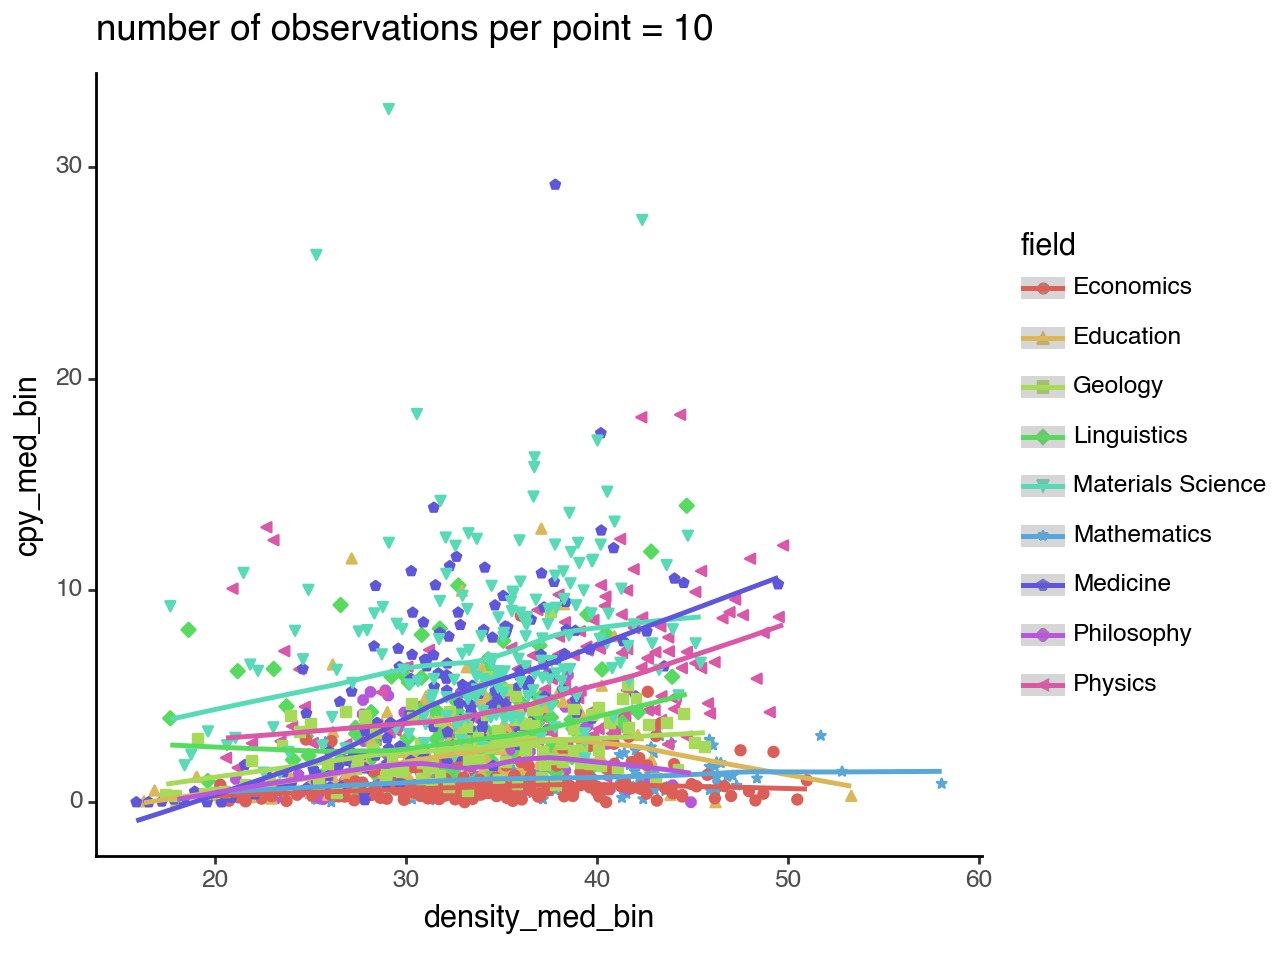

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

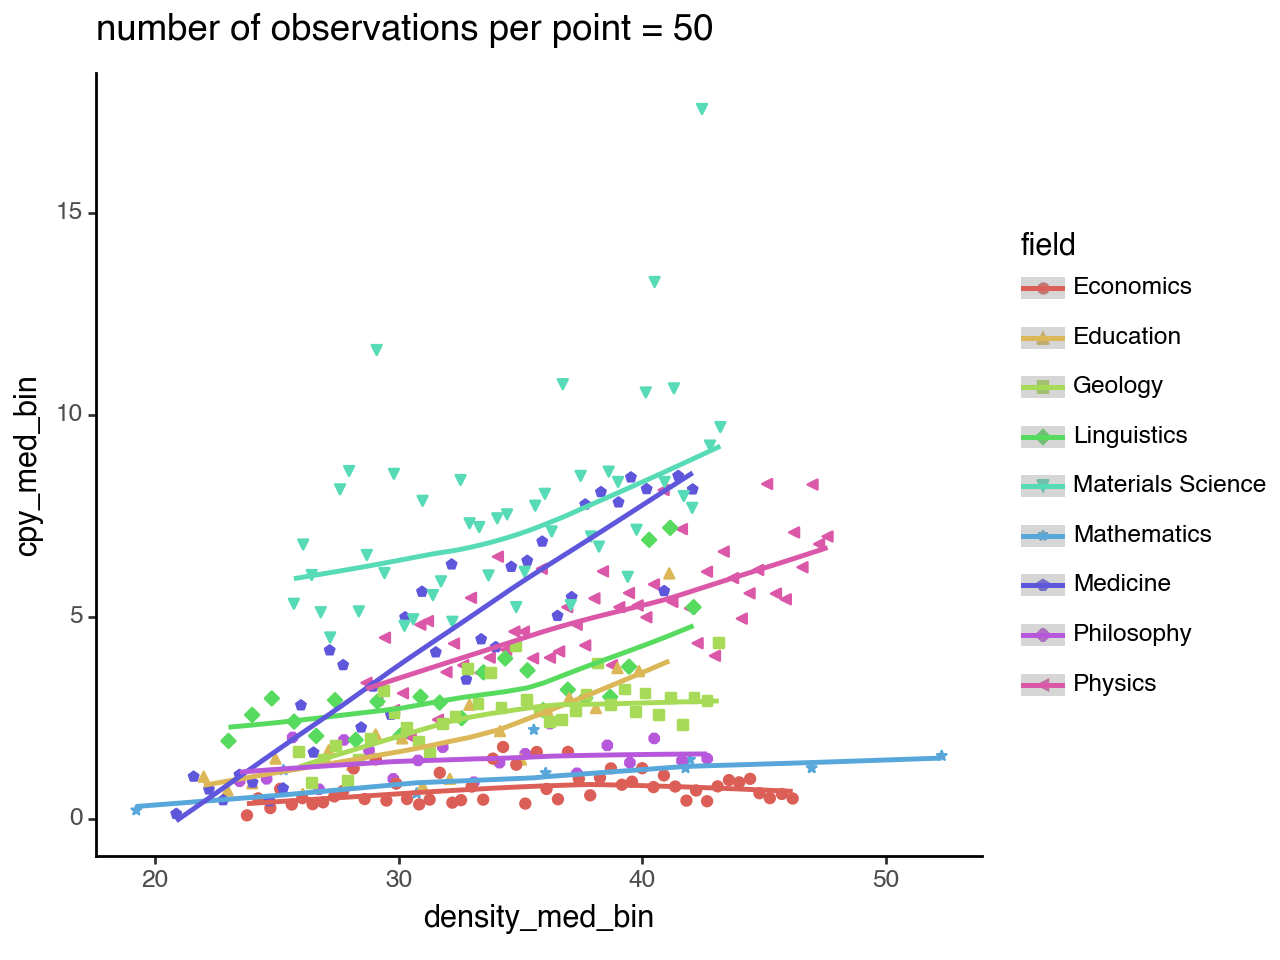

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

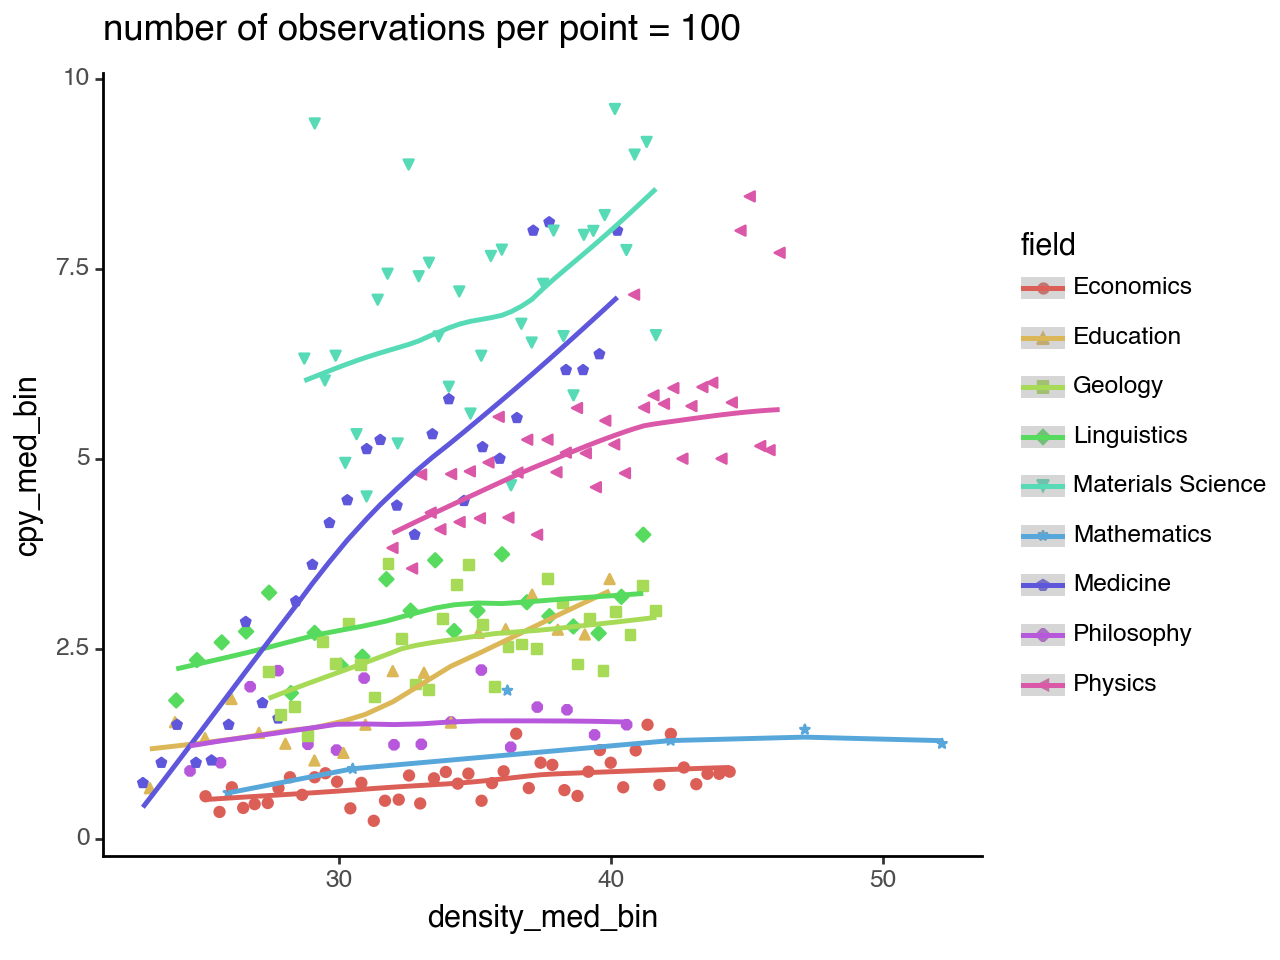

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

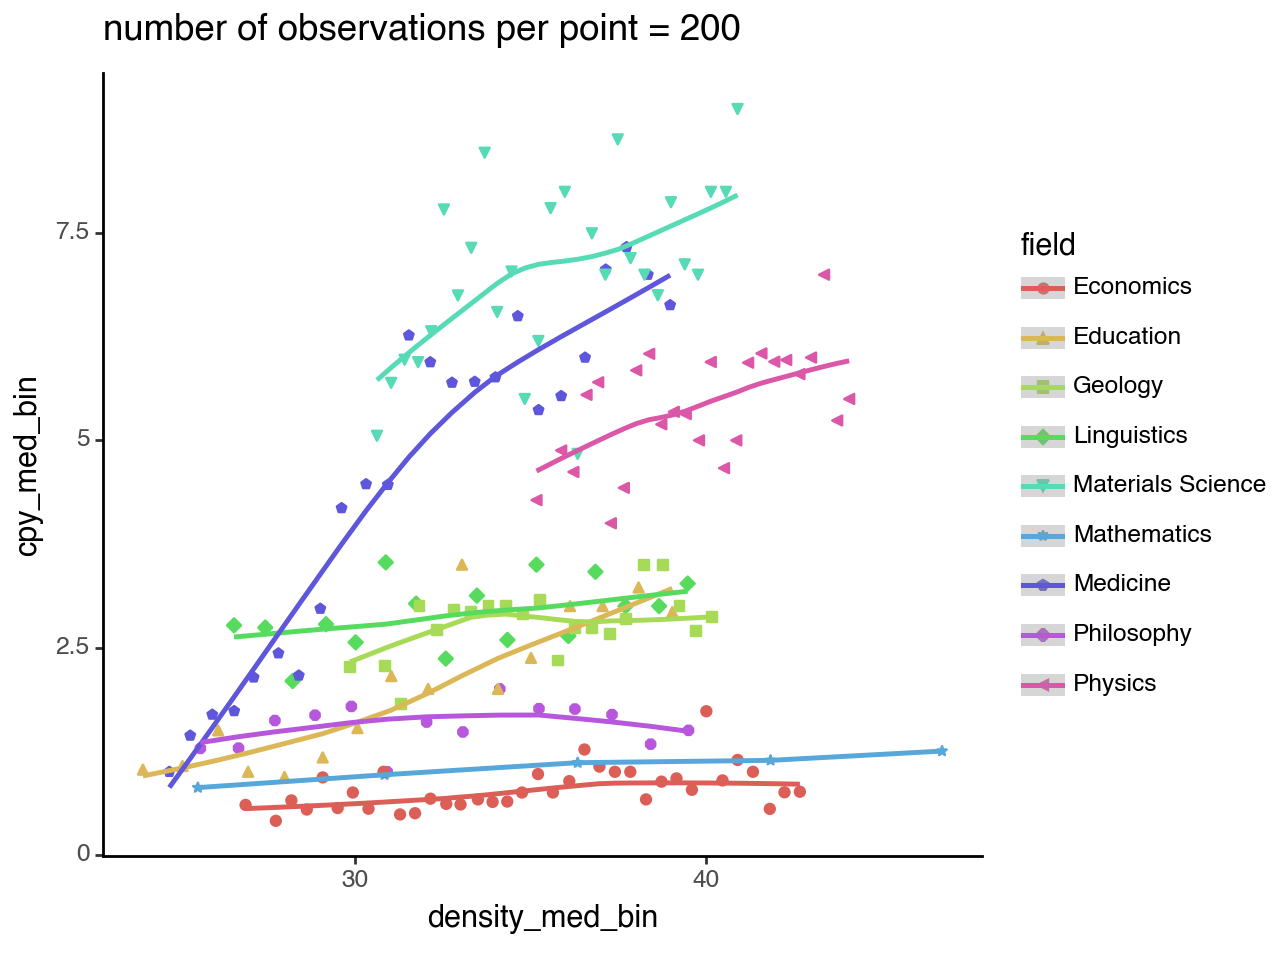

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

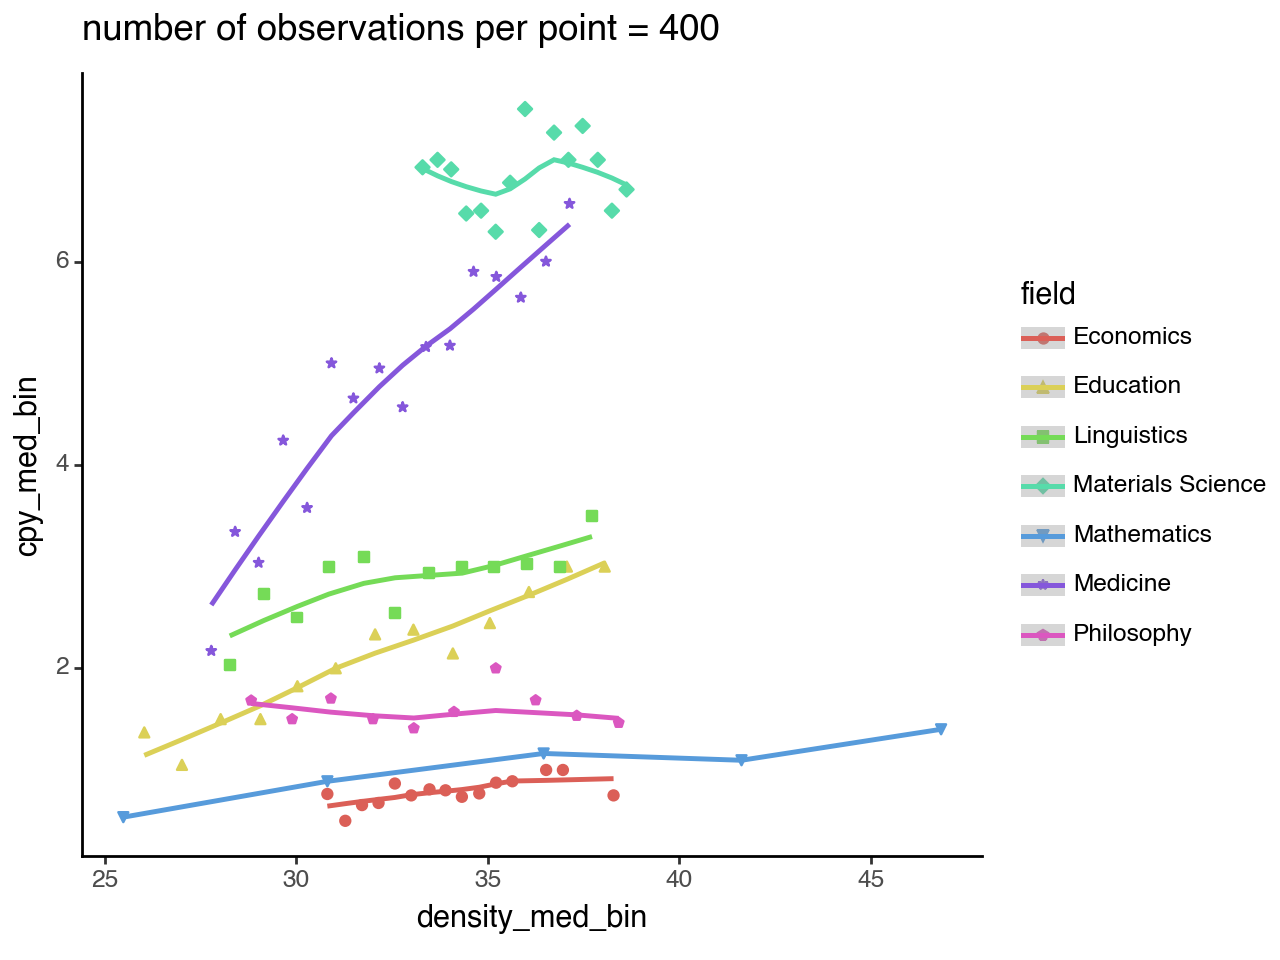

In [652]:
for n_bin in [10, 50, 100, 200, 400]:

    print(
        pn.ggplot(
            pd.concat(
            [get_df_var(df, field, n_bin=n_bin)
            for field in df["fields_of_study_0"].unique()],
            ),
            pn.aes(
                x="density_med_bin",
                # y="log_cpy_med_bin",
                # y="log_cpy_var",
                y="cpy_med_bin",
                # y="cpy_var",
                # color="field",
                # shape="field",
            )
        )
        # + pn.facet_wrap("field")
        + pn.geom_point(
            pn.aes(
                shape="field",
                color="field",
            ),
            # color="black",
            # alpha=0.1,
        )
        + pn.geom_smooth(
            pn.aes(
                color="field",
            )
        )
        # + pn.ylab("Variance in citations per year")
        # + pn.xlab("Prior density of neighborhood")
        + pn.theme_classic()
        # + pn.ylim(0,2)
        + pn.ggtitle(f"number of observations per point = {n_bin}")
    )

In [653]:
pd.concat(
    [get_df_var(df, field, n_bin=100)
    for field in df["fields_of_study_0"].unique()],
).to_csv("dmb_vs_log_cpy_var.csv", index=False)

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [654]:
# debug counts
get_df_ent(df, "Physics")

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/437039298.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


density_bin      freq  count  log_cpy entropy  log_cpy variance  \
0        16.421  0.002151     24              NaN          0.292892   
1        18.205  0.002868     32              NaN          0.494681   
2        19.988  0.004661     52              NaN          0.347589   
3        21.771  0.005916     66              NaN          0.439048   
4        23.555  0.008426     94              NaN          0.426628   
5        25.338  0.012908    144              NaN          0.522535   
6        27.121  0.020617    230              NaN          0.427345   
7        28.904  0.029849    333              NaN          0.503837   
8        30.688  0.040875    456              NaN          0.386171   
9        32.471  0.052886    590              NaN          0.331740   
10       34.254  0.085246    951              NaN          0.287177   
11       36.038  0.118501   1322              NaN          0.271986   
12       37.821  0.142345   1588              NaN          0.232589   
13       39.604  0.150950   1684              NaN          0.213364   
14       41.388  0.135891   1516              NaN          0.214872   
15       43.171  0.101560   1133              NaN          0.215079   
16       44.954  0.055844    623              NaN          0.214764   
17       46.737  0.021065    235              NaN          0.216804   
18       48.521  0.005916     66         5.677022          0.180052   
19       50.304  0.001524     17         9.450469          0.155624   

    log_cpy median      cpy_var    cpy_med   cpy_mean    field  
0         0.522879    17.356199   0.919643   2.843416  Physics  
1         0.825050   209.167170   1.928571   8.066955  Physics  
2         0.592076  1499.771678   2.464286  10.335800  Physics  
3         0.933656   340.519697   4.875000  12.758445  Physics  
4         0.787866   707.713159   4.000000  13.586317  Physics  
5         0.568202  5655.035631   2.200980  15.332199  Physics  
6         0.753328  2261.595311   4.107955  13.425379  Physics  
7         0.590478   675.663151   2.769231  10.375257  Physics  
8         0.675167   716.974819   4.035714  11.007065  Physics  
9         0.684247  8797.634635   4.333333  12.818036  Physics  
10        0.698970   174.712014   4.666667   8.700456  Physics  
11        0.690599   884.224829   4.750000   9.620228  Physics  
12        0.732394   160.595161   5.212406   8.766821  Physics  
13        0.742679   165.581710   5.477273   9.322811  Physics  
14        0.778151   357.766136   6.000000  10.387770  Physics  
15        0.785028   174.626782   6.000000  10.163338  Physics  
16        0.845098   178.931251   7.000000  11.349508  Physics  
17        0.872146   169.811223   7.400000  11.685144  Physics  
18        0.852718   239.502967   7.125000  11.301659  Physics  
19        1.000000    36.022932  10.000000  10.392588  Physics

In [655]:
df_ent_all = pd.concat(
    [get_df_ent(df, field, num_bins=100)
    for field in df_all["fields_of_study_0"].unique()],
)
df_ent_all

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/437039298.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/1151388027.py:28: RuntimeWarning: divide by zero encountered in divide
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/1151388027.py:28: RuntimeWarning: invalid value encountered in divide
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/437039298.py:31: RuntimeWarning: Degrees of freedom <= 0 for slice.
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/437039298.py:44: RuntimeWarning: All-NaN slice encountered
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/437039298.py:9: SettingWithCopyWarning

density_bin      freq  count  log_cpy entropy  log_cpy variance  \
0        16.421  0.000359      4              NaN          0.032385   
1        16.778  0.000717      8              NaN          0.120239   
2        17.135  0.000269      3              NaN               NaN   
3        17.491  0.000717      8              NaN          0.354091   
4        17.848  0.000090      1              NaN          0.000000   
..          ...       ...    ...              ...               ...   
95      575.657  0.000000      0              NaN               NaN   
96      581.553  0.000000      0              NaN               NaN   
97      587.450  0.000000      0              NaN               NaN   
98      593.346  0.000000      0              NaN               NaN   
99      599.243  0.000086      1              NaN          0.000000   

    log_cpy median    cpy_var    cpy_med   cpy_mean        field  
0         0.866340  20.875060   2.428571   3.995536      Physics  
1         0.522879   5.351015   2.452381   2.935944      Physics  
2              NaN   0.000000   0.000000   0.000000      Physics  
3         0.425969   3.378488   0.258929   1.400108      Physics  
4         1.244807   0.000000  17.571429  17.571429      Physics  
..             ...        ...        ...        ...          ...  
95             NaN        NaN        NaN        NaN  Mathematics  
96             NaN        NaN        NaN        NaN  Mathematics  
97             NaN        NaN        NaN        NaN  Mathematics  
98             NaN        NaN        NaN        NaN  Mathematics  
99        0.716882   0.000000   5.210526   5.210526  Mathematics  

[900 rows x 10 columns]

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


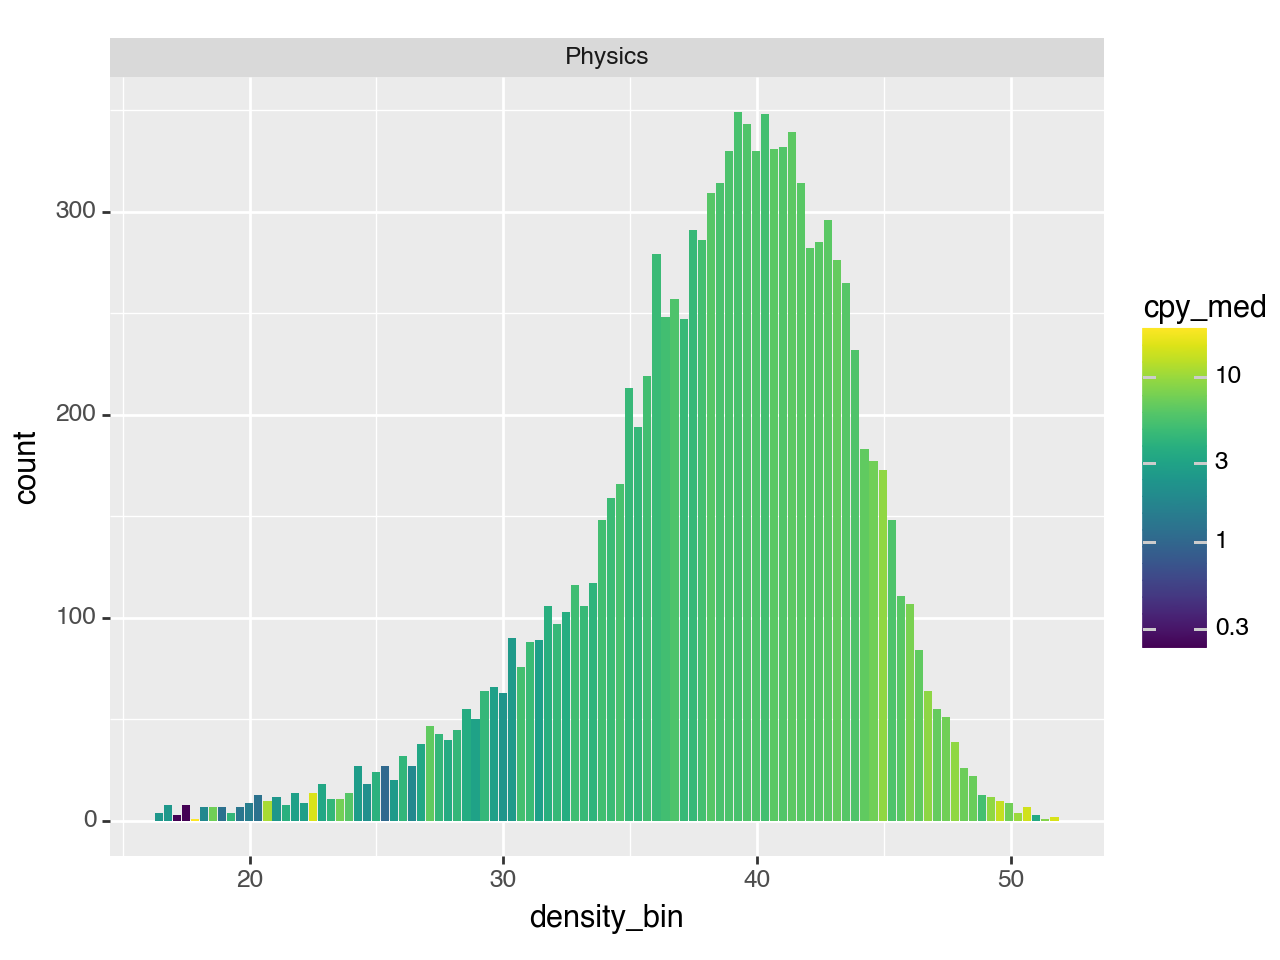

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


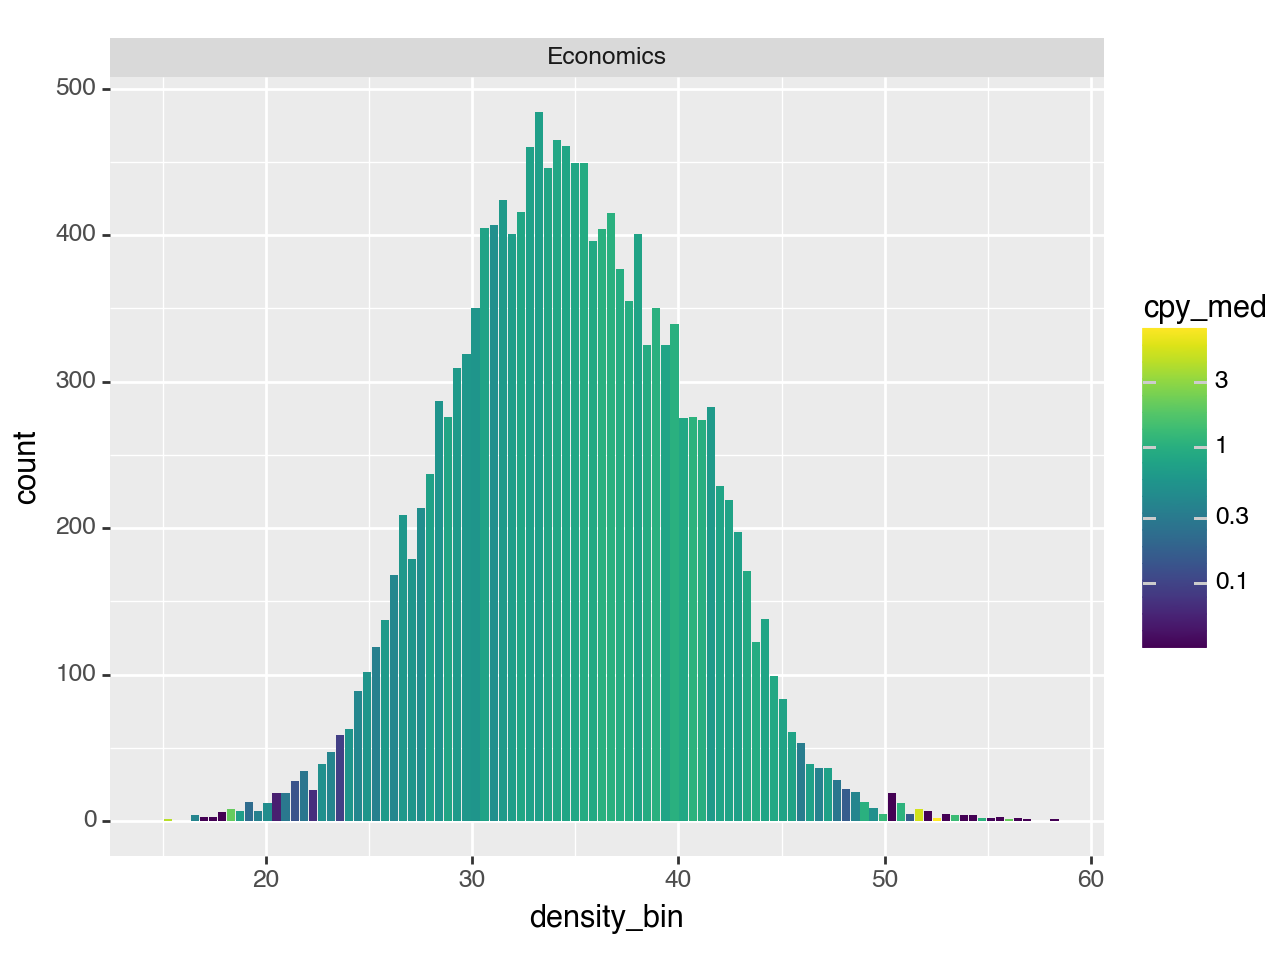

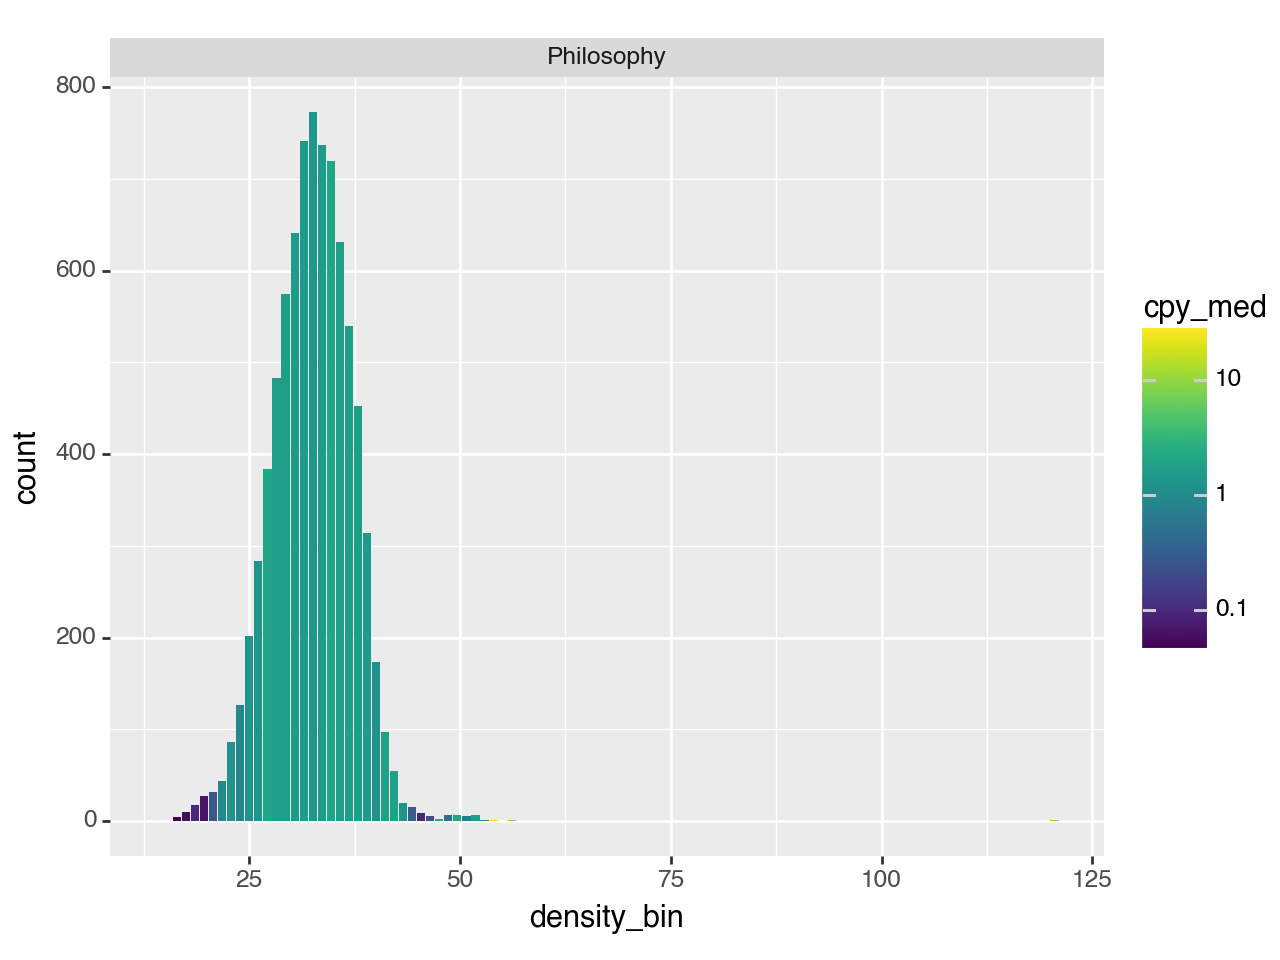

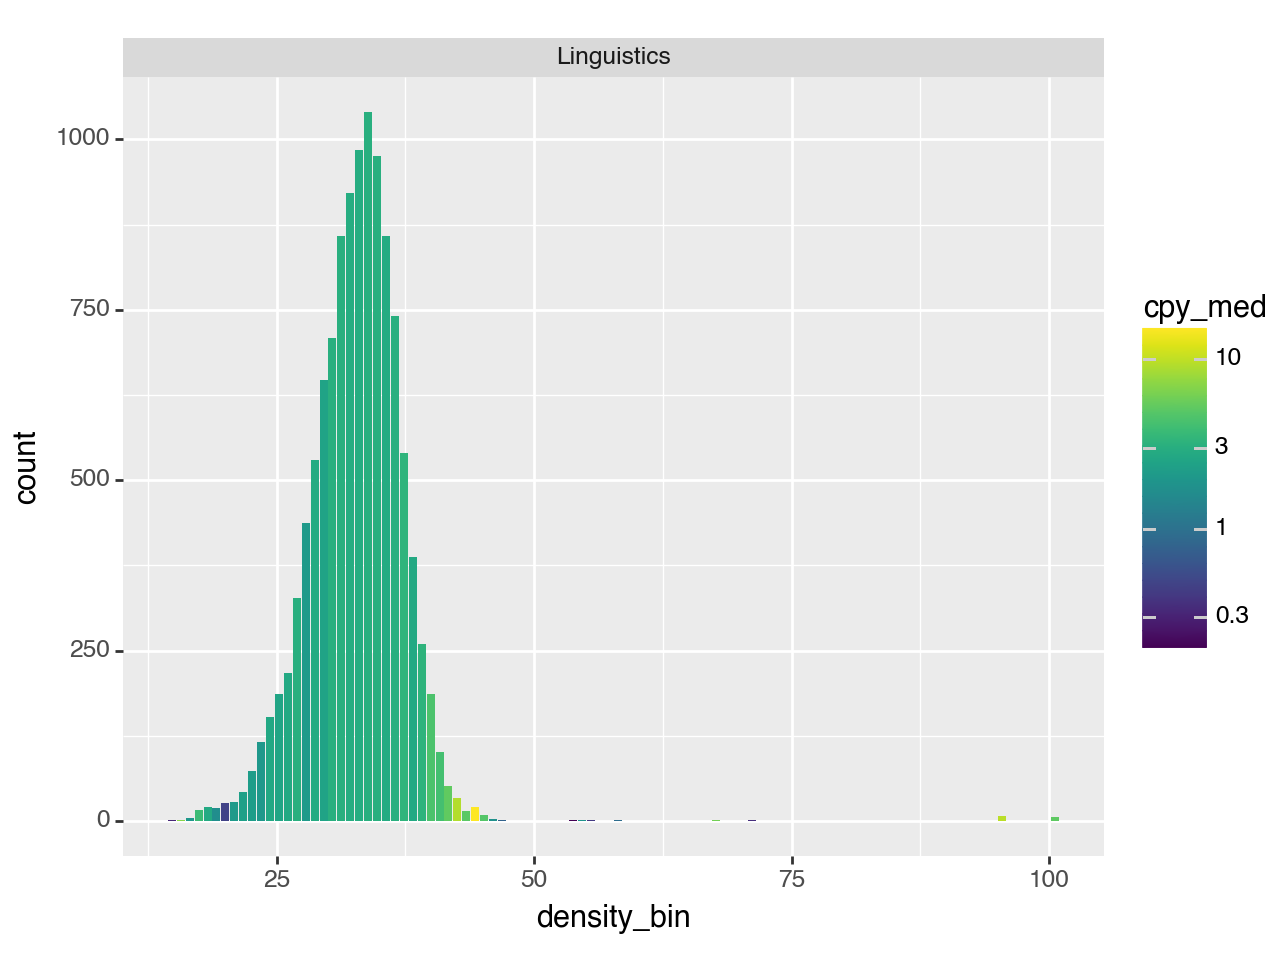

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


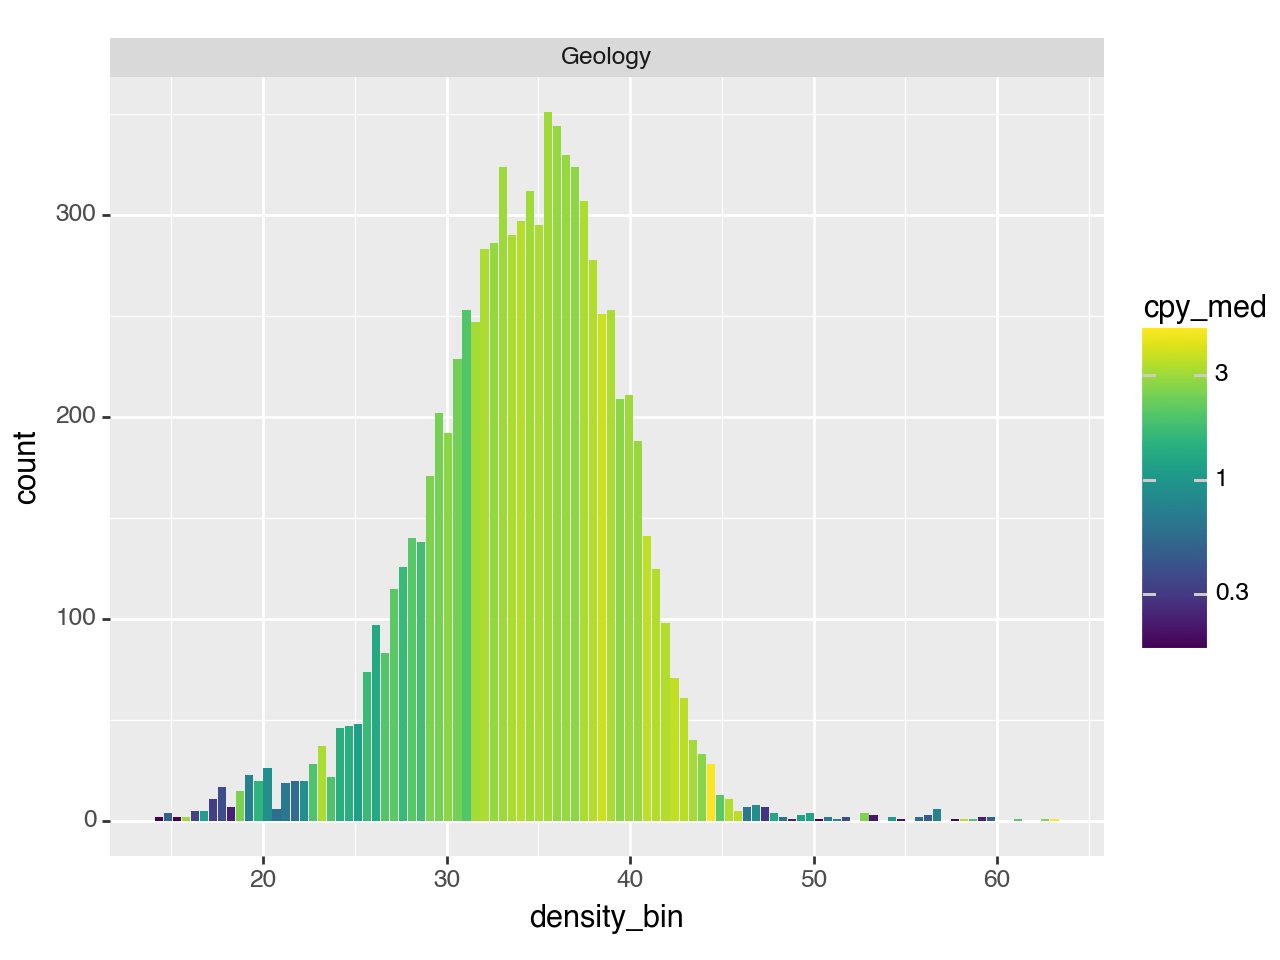

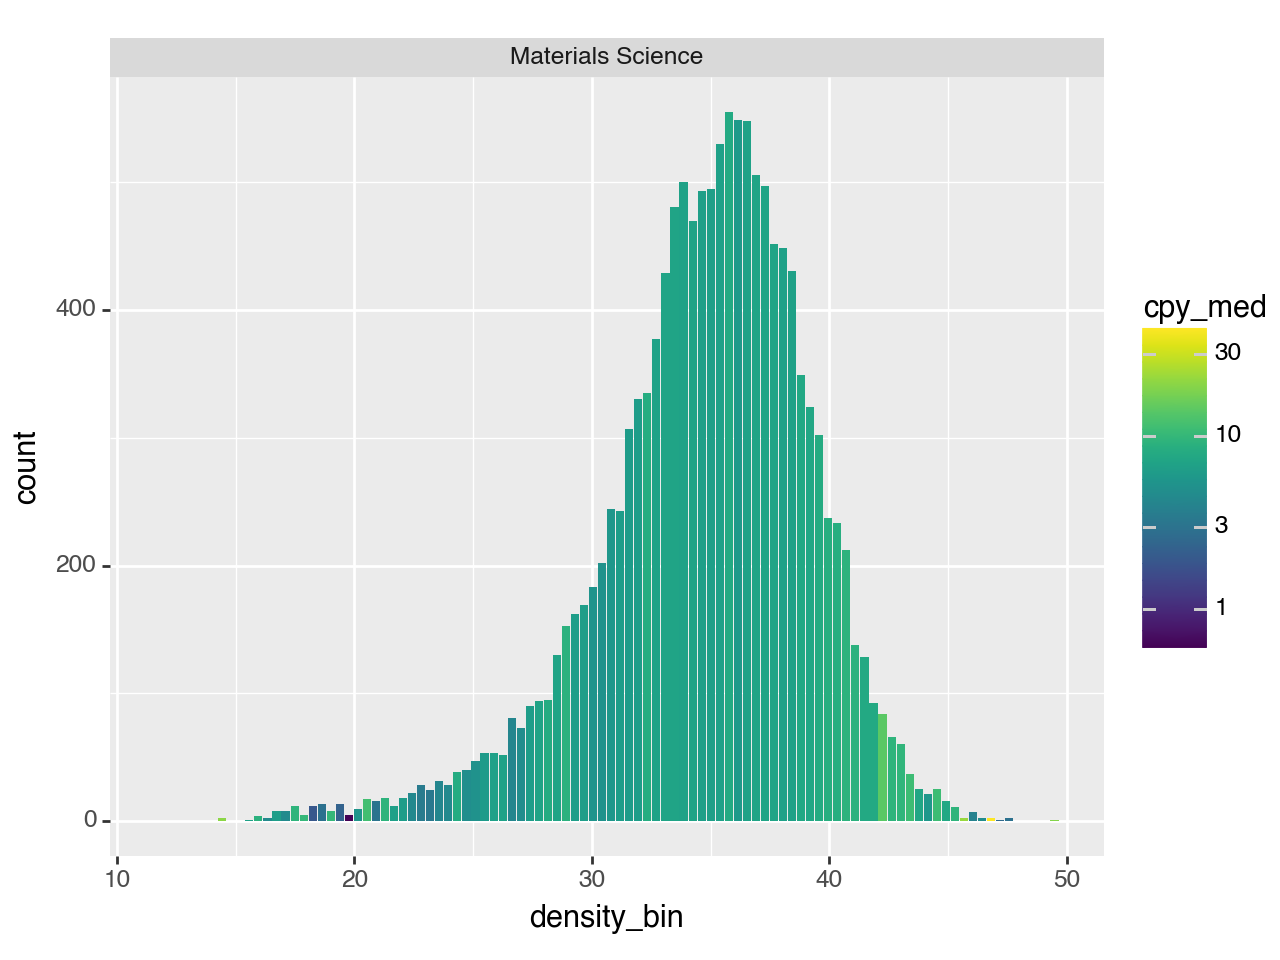

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


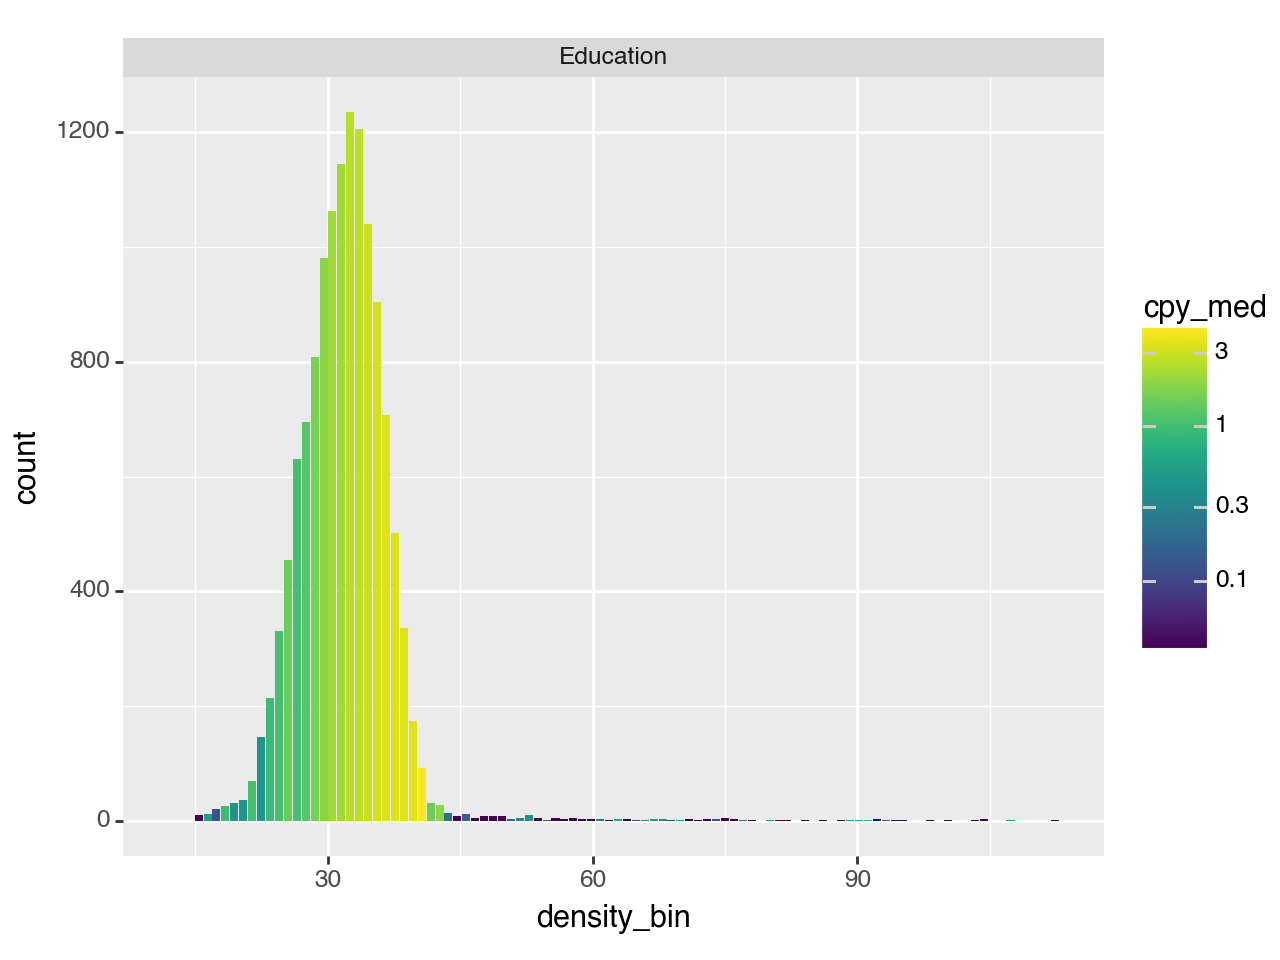

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10


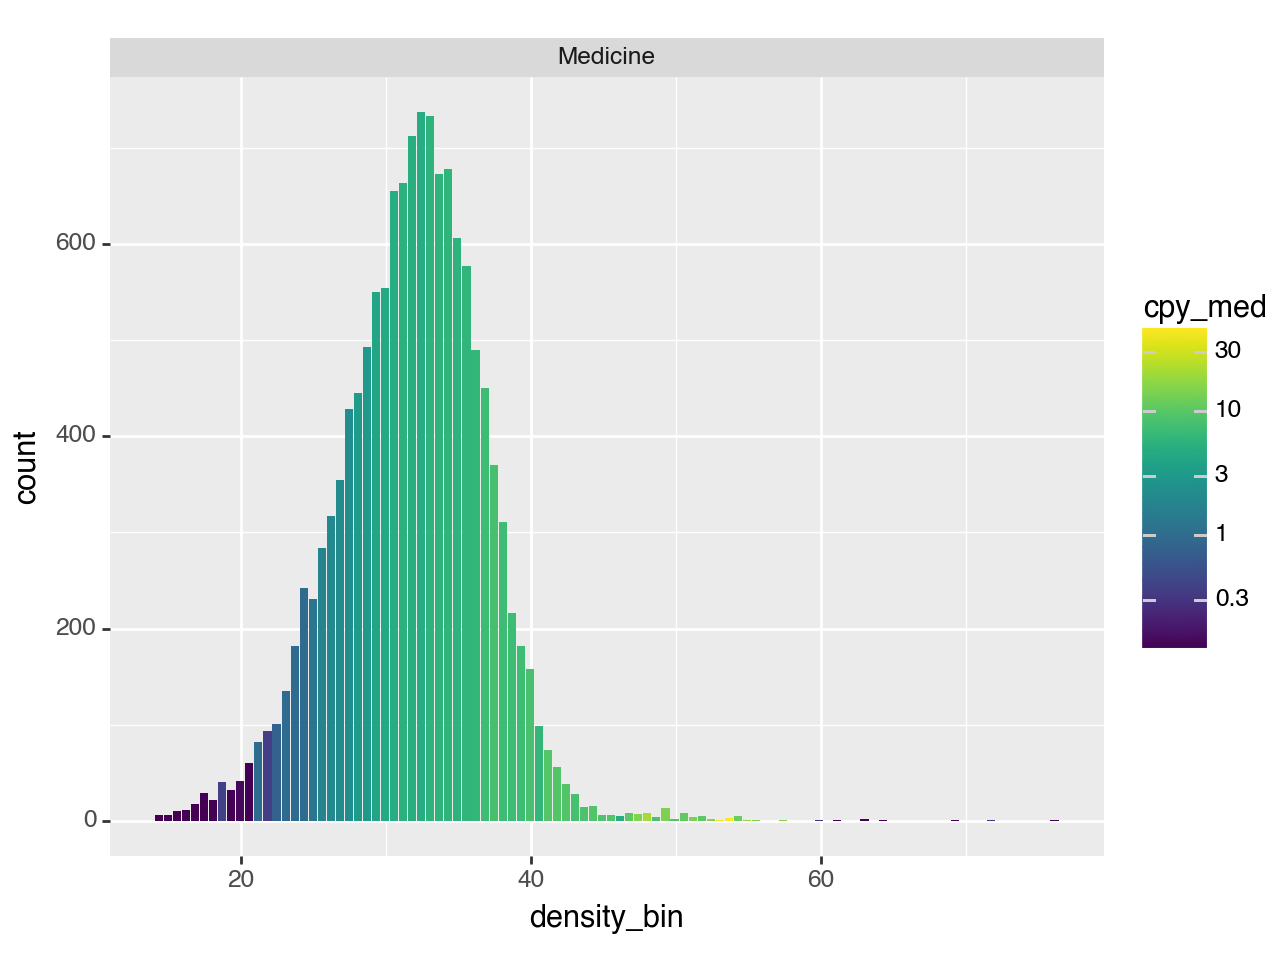

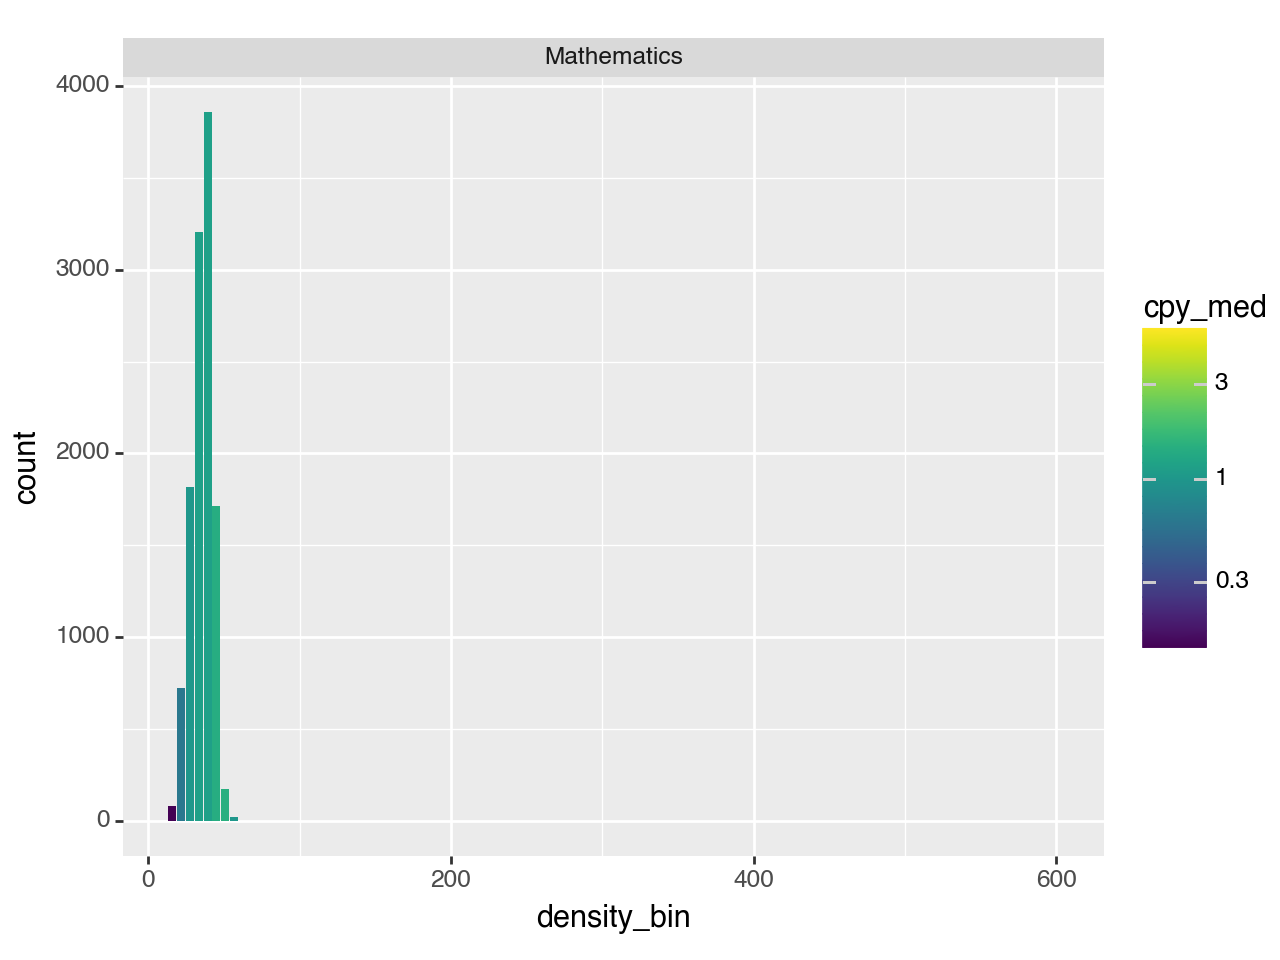

In [656]:
# First global, then facet by fields

# faceting isn't working so we're looping
for field in df_ent_all.field.unique():
    print(
        pn.ggplot(
            df_ent_all[df_ent_all["field"] == field], 
        )
        + pn.facet_wrap("field")
        + pn.geom_col(pn.aes(
            x="density_bin",
            # fill="citation entropy",
            # fill="log_cpy variance",
            # fill="cpy_var",
            fill="cpy_med",
            # fill="log_cpy median",
            y="count",
        ),size=10,
        )
        # + pn.labs(fill="citation entropy,\nH(CPY | density_bin)\n")
        + pn.scale_fill_continuous(trans = "log10")
    )


In [657]:
df_ent_all["log_cpy_variance"] = df_ent_all["log_cpy variance"]

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/cit

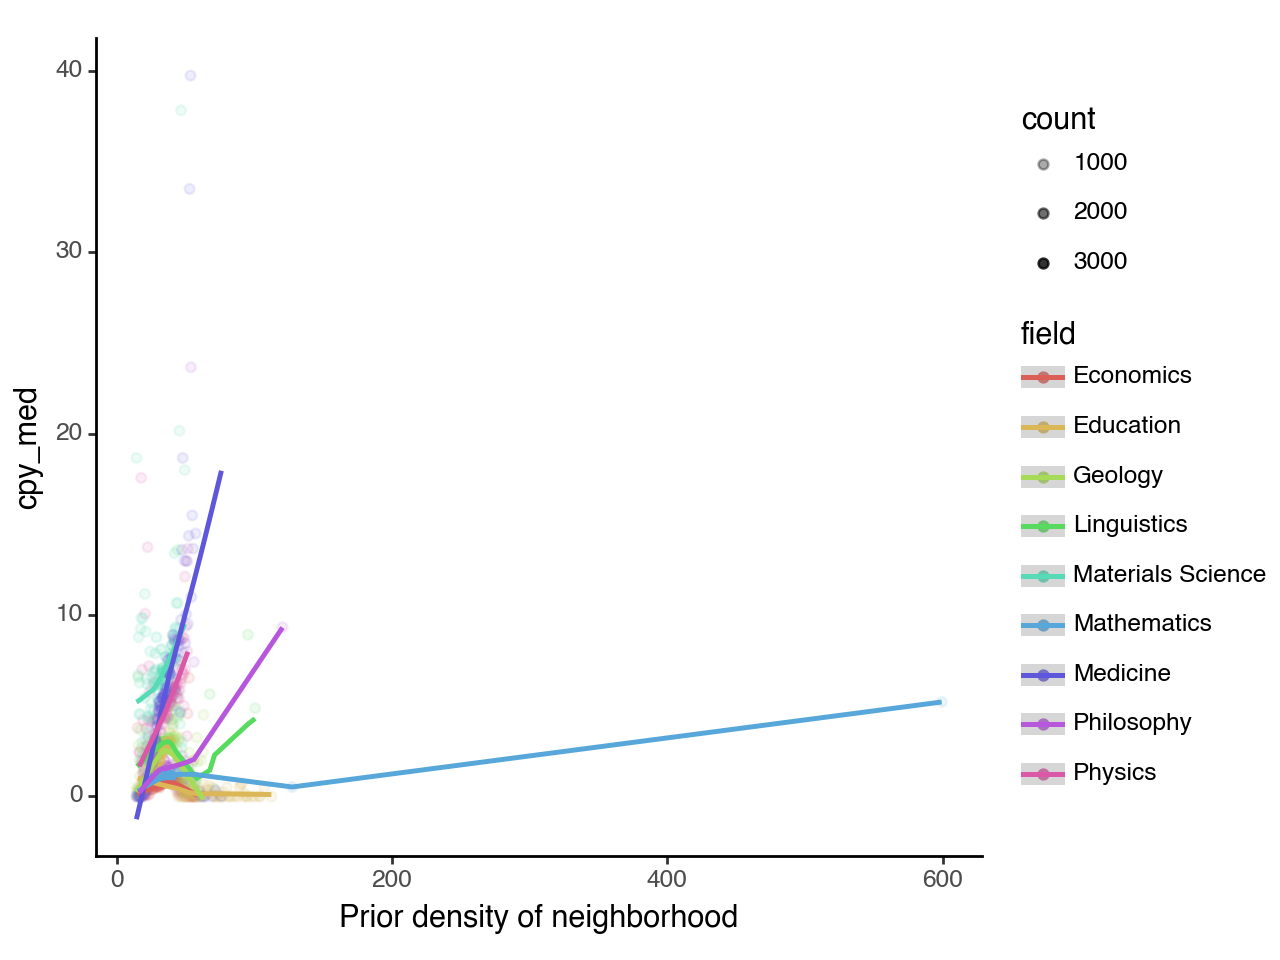

<Figure Size: (640 x 480)>

In [658]:
from scipy.stats import linregress

(
        pn.ggplot(
            df_ent_all[df_ent_all["count"] > 0], 
            pn.aes(
                x="density_bin",
                # y="log_cpy variance",
                y="cpy_med",
                color="field",
                # shape="field",
            )
        )
        # + pn.facet_wrap("field")
        + pn.geom_point(
            pn.aes(
                # size="freq",
                alpha="count",      
            )
        )
        + pn.geom_smooth(
            pn.aes(
                # color="field",
            ),
            # color="black",
        )
        # + pn.ylab("Variance in log citations per year")
        + pn.xlab("Prior density of neighborhood")
        + pn.theme_classic()
)

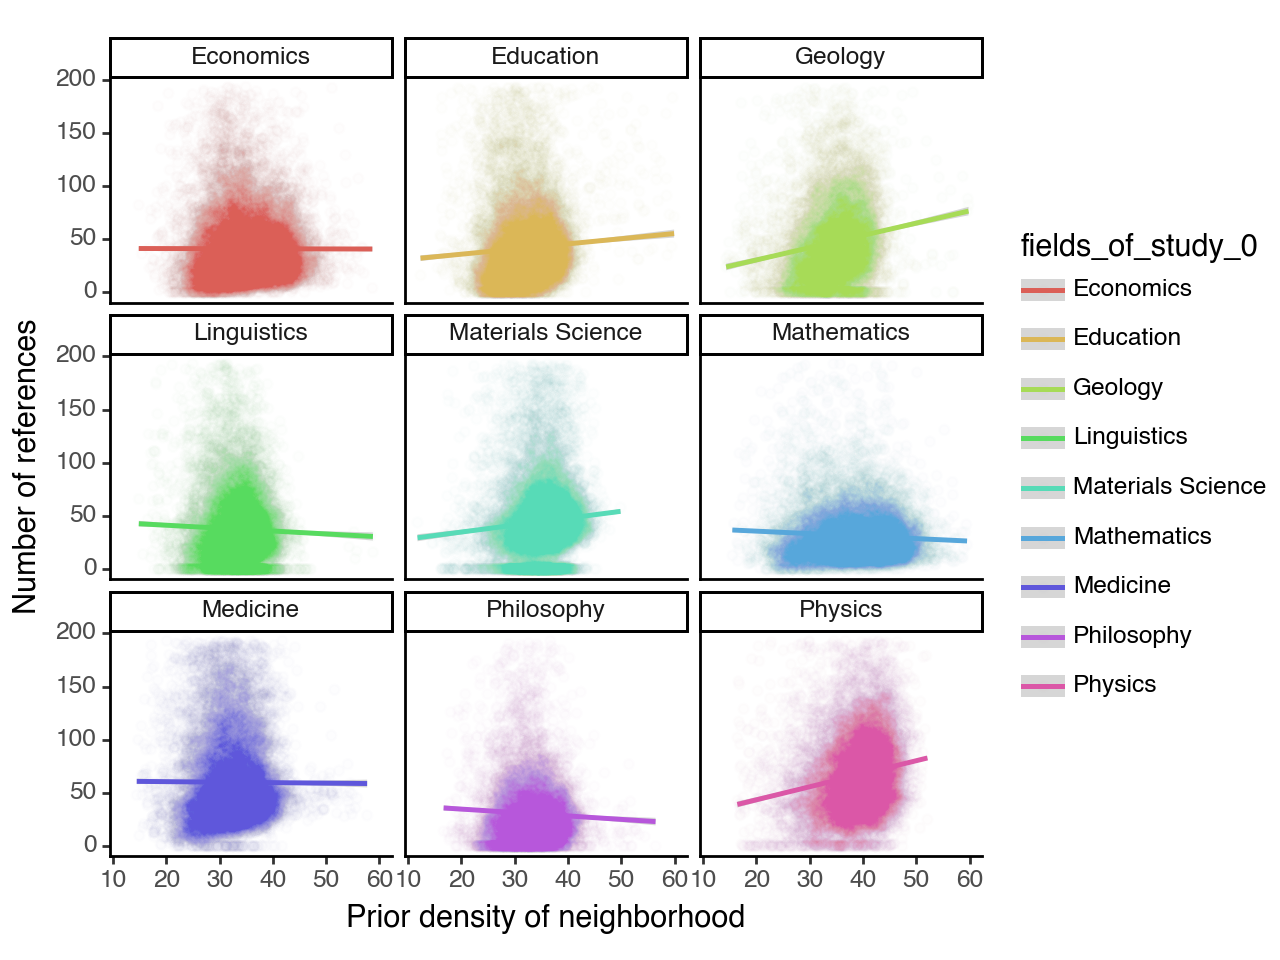

<Figure Size: (640 x 480)>

In [659]:
# Let's visualize reference length for all fields.

df_temp =  df[df["density"] < 60]
df_temp = df_temp[df_temp.references < (df_temp.references.mean())+2*df_temp.references.std()]

(
    pn.ggplot(
        df_temp,
        # df,
        pn.aes(
            x="density",
            y="references",
            color="fields_of_study_0",
        )
    )
    # + pn.scale_y_log10()
    + pn.geom_point(alpha=0.01)
    + pn.geom_smooth()
    + pn.facet_wrap("fields_of_study_0")
    + pn.xlab("Prior density of neighborhood")
    + pn.ylab("Number of references")
    + pn.theme_classic()
    # TODO: annotate each line with R^2, p-values
    # TODO: normalize each by the average number of references per field
)

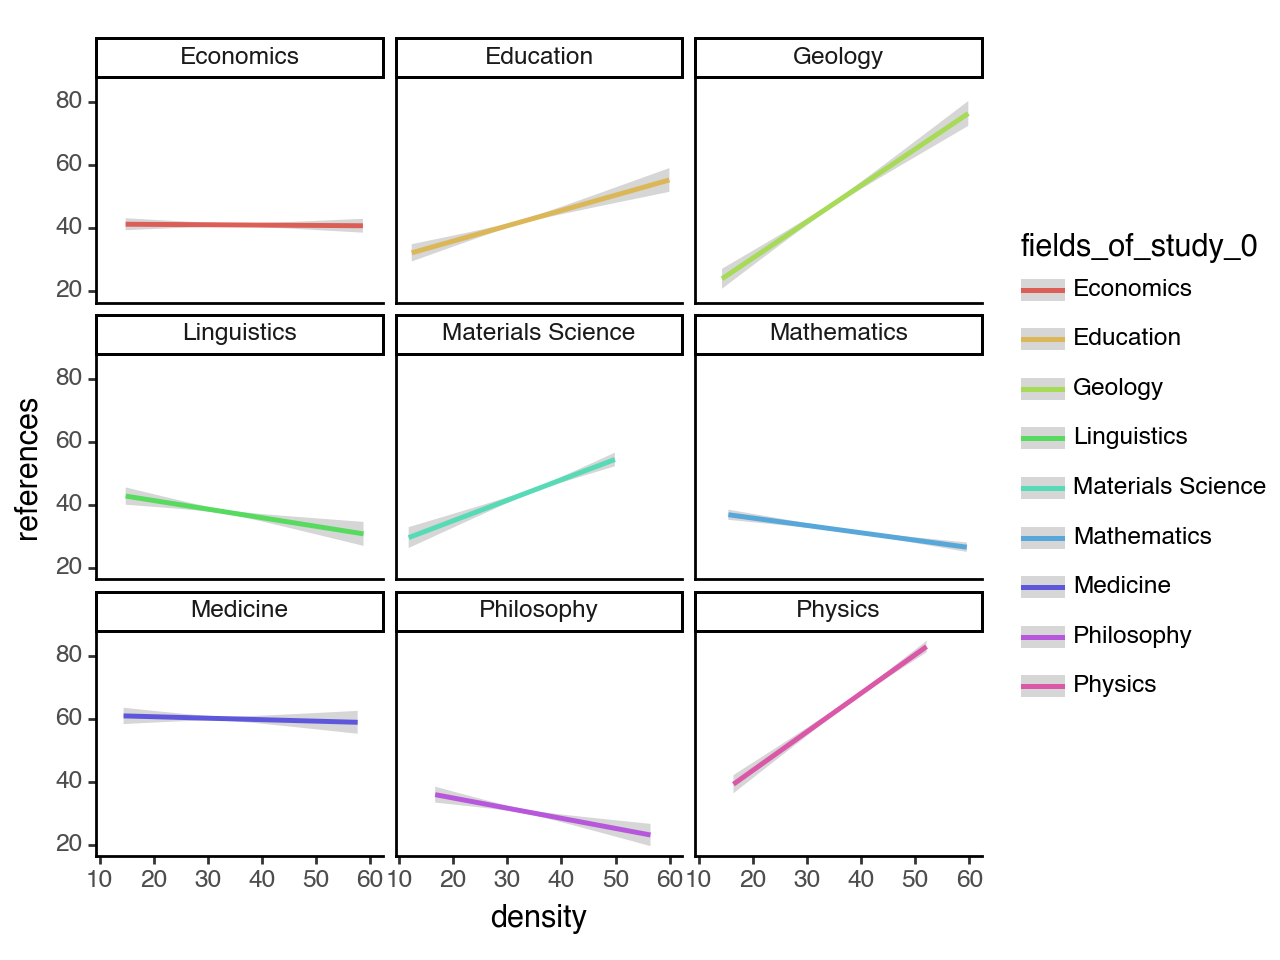

<Figure Size: (640 x 480)>

In [660]:
(
    pn.ggplot(
        df_temp,
        # df,
        pn.aes(
            # x="references",
            # y="log_cpy",
            x="density",
            y="references",
            color="fields_of_study_0",
        )
    )
    # + pn.scale_y_log10()
    # + pn.geom_point(alpha=0.01)
    # + pn.geom_hline( pn.aes(yintercept=df_temp.log_cpy.median().item()) )
    + pn.geom_smooth()
    + pn.facet_wrap("fields_of_study_0")
    + pn.theme_classic()
)

In [661]:
# try in R, maybe its prettier.
df_ent_all.to_csv("all_cpy_variance_data.csv", index=False)

In [662]:
df.year.value_counts()

year
2018    7429
2017    7266
2019    7240
2016    7191
2015    7179
2014    7067
2013    6952
2012    6640
2011    6253
2010    5822
2009    5405
2008    5196
2007    4768
2006    4422
2005    4151
2004    3759
2003    3509
2002    3122
2001    2784
Name: count, dtype: int64

In [663]:
df_mpl

density_med_bin  cpy_med_bin  cpy_mean_bin  log_cpy_med_bin     cpy_var  \
0         37.985547     7.437500     13.821579         0.875061  532.505379   
1         41.556924     7.875000     14.594167         0.942008  421.140446   
2         39.440096     5.805556     11.535976         0.786120  267.245314   
3         43.740503     8.083333     12.792524         0.907567  267.903560   
4         44.028744     6.000000      9.299579         0.778151   63.257214   
..              ...          ...           ...              ...         ...   
42        42.275827     0.916667      3.560095         0.062469   40.470251   
43        34.544836     1.000000      3.102643         0.176091   24.117723   
44        48.583048     1.500000      3.781714         0.425969   38.401458   
45        30.056358     0.937500      5.371143         0.522879  117.151232   
46        31.864499     0.833333      2.785937         0.278754   25.655144   

    log_cpy_var        field  
0      0.197104      Physics  
1      0.201540      Physics  
2      0.289850      Physics  
3      0.190208      Physics  
4      0.173300      Physics  
..          ...          ...  
42     0.440956  Mathematics  
43     0.304817  Mathematics  
44     0.433163  Mathematics  
45     0.448748  Mathematics  
46     0.391886  Mathematics  

[343 rows x 7 columns]

#### Zach style main trend plot from ads paper

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/319405436.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

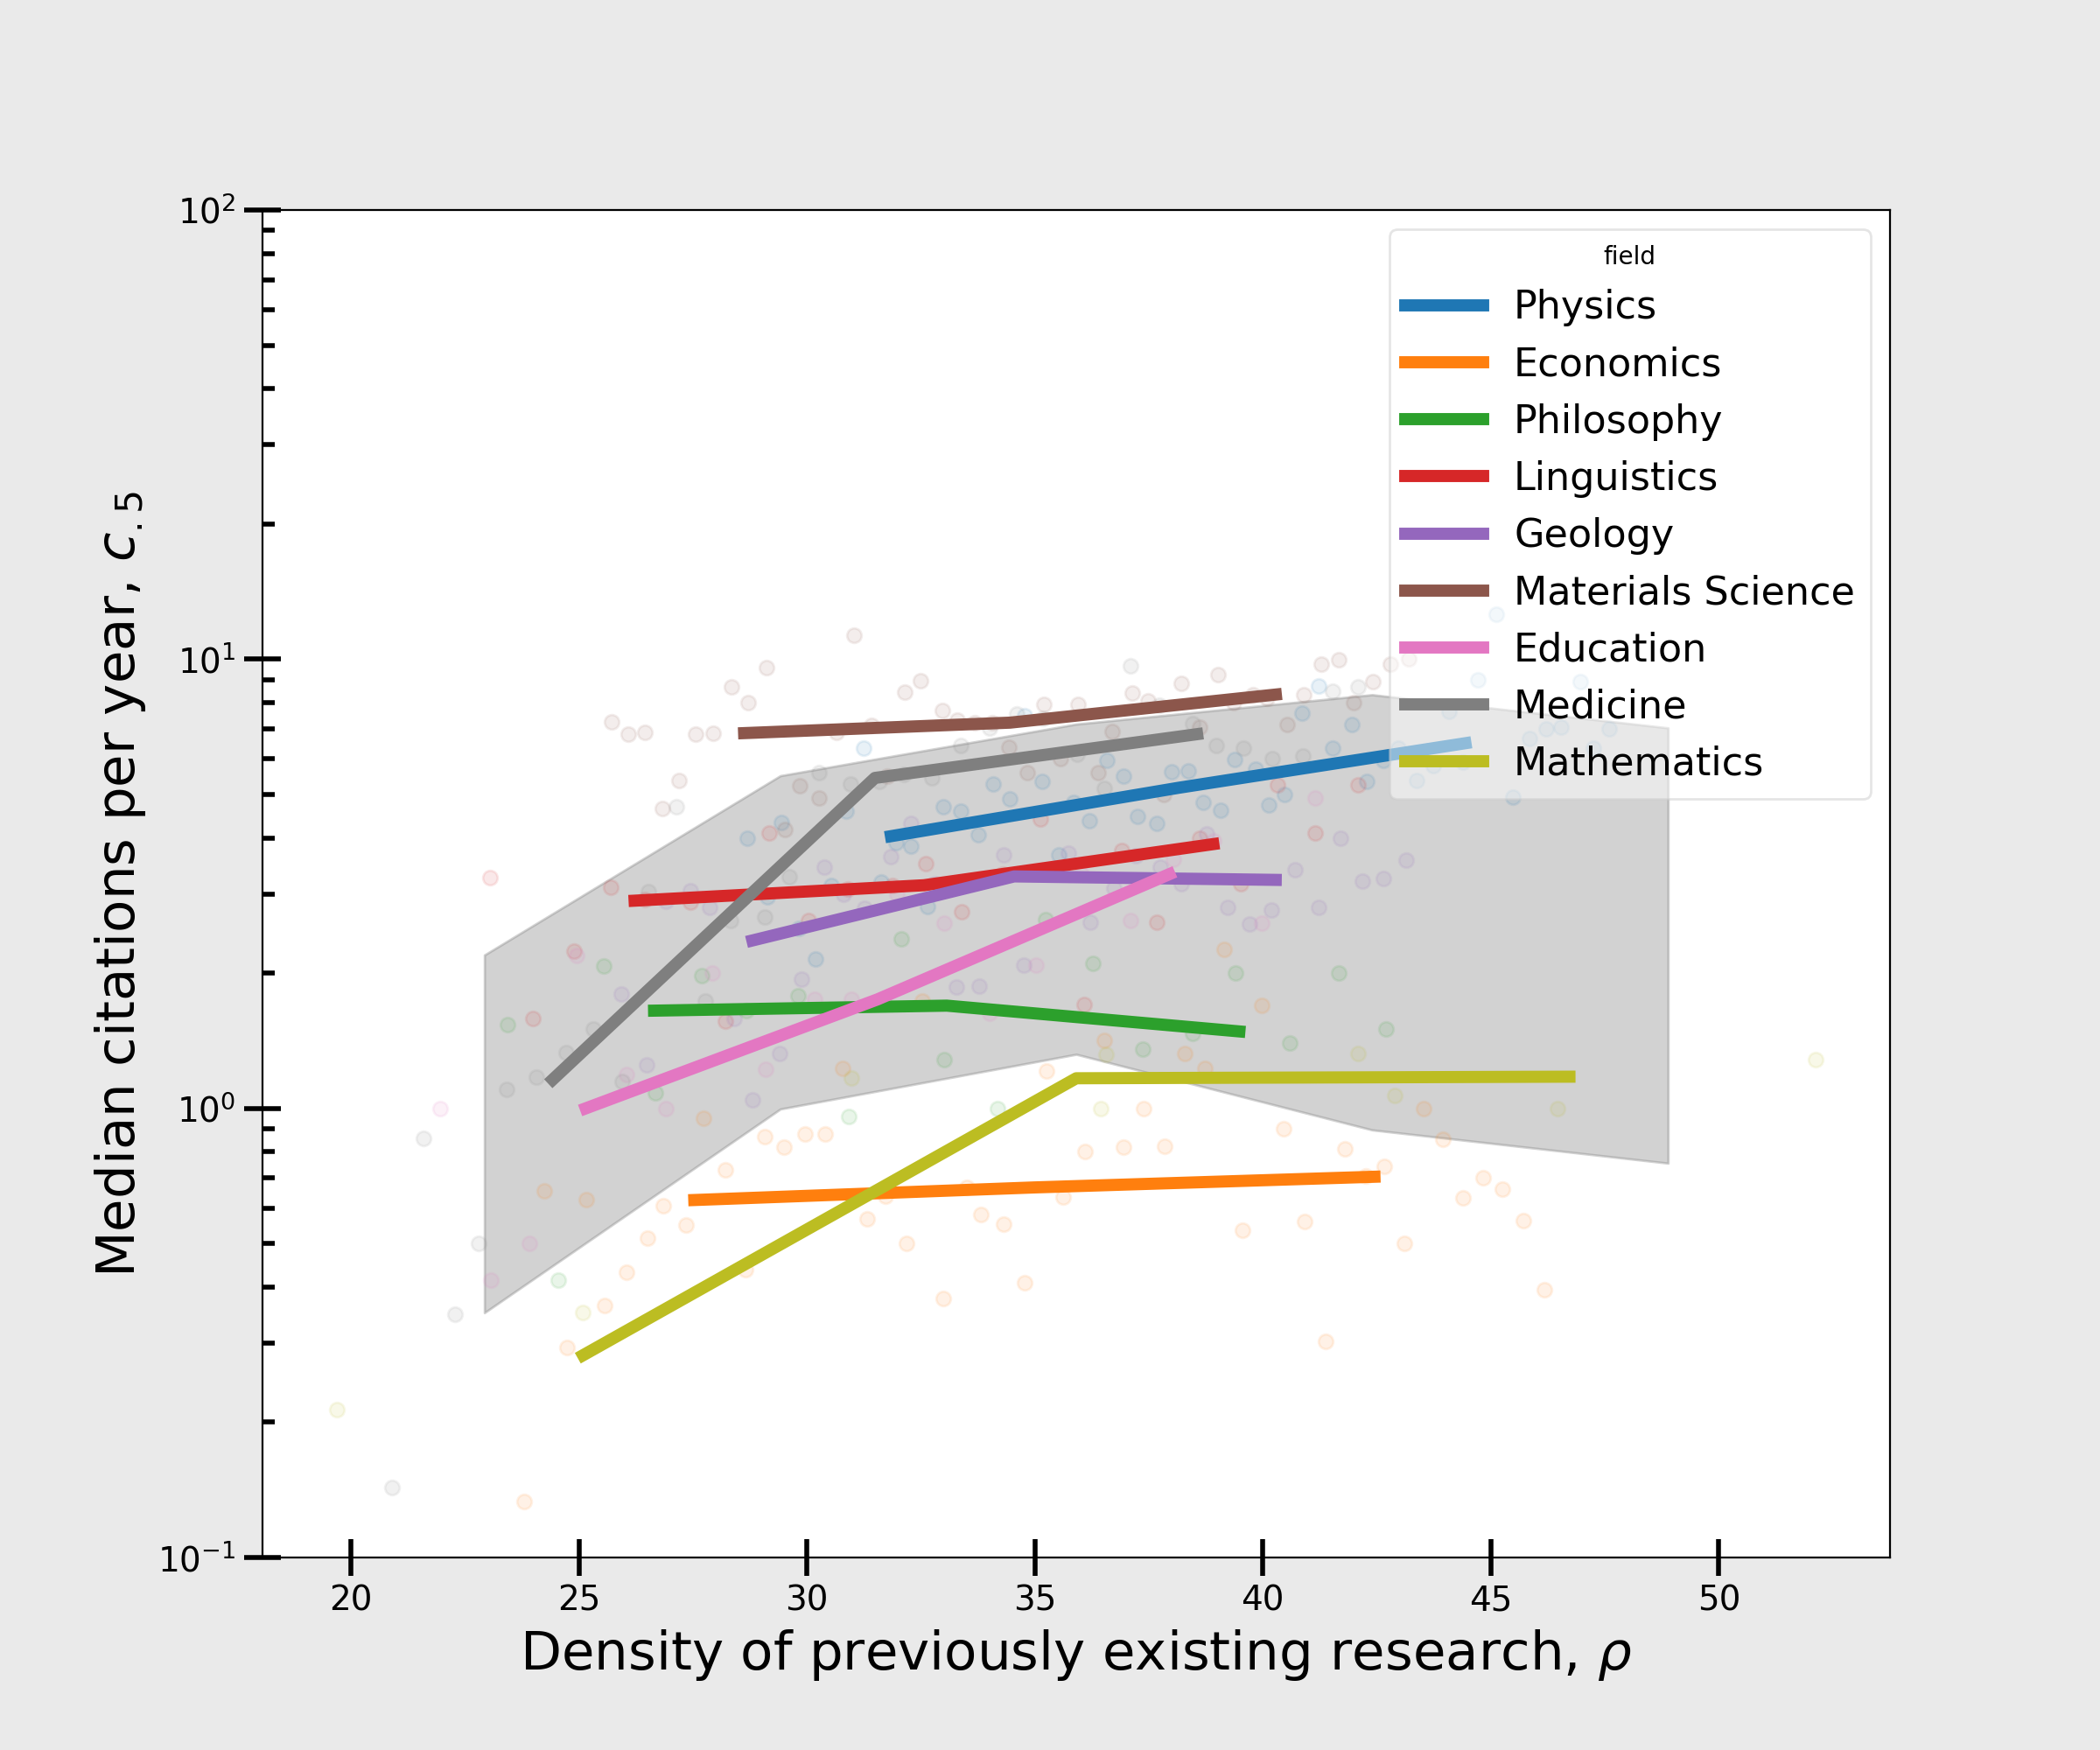

In [664]:
import matplotlib
import matplotlib.pyplot as plt
import scipy


# df_mpl = pd.read_csv("dmb_vs_log_cpy_var.csv")
df_mpl = pd.concat(
    [get_df_var(df, field, n_bin=50)
    for field in df["fields_of_study_0"].unique()],
)


facecolor = np.array([ 235, 235, 235 ]) / 256.
fig = plt.figure( figsize=(12, 5*2), facecolor = facecolor )
ax = plt.gca()

e_n = df_mpl["density_med_bin"]

mult = 1.

cpy_v = df_mpl["cpy_med_bin"]
# ax.scatter(
#     mult * e_n,
#     cpy_v,
#     color = 'k',
#     alpha = 0.1,
# )

# Setup bins

bin_edges = np.linspace(
    e_n.min(),
    e_n.max(),
    # np.nanmean( e_n ) - 2.*np.nanstd( e_n ),
    # np.nanmean( e_n ) + 2.*np.nanstd( e_n ),
    6,
)

xs = bin_edges[:-1] + 0.5 * ( bin_edges[1] - bin_edges[0] )

# Binned median
# binned_median_color = cmap[k]
median, bin_edges, _ = scipy.stats.binned_statistic( e_n, cpy_v, 'median', bins=bin_edges )
upper_fn = lambda y: np.nanpercentile( y, 84 )
upper, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, upper_fn, bins=bin_edges )
lower_fn = lambda y: np.nanpercentile( y, 16 )
lower, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, lower_fn, bins=bin_edges )
ax.fill_between(
    mult * xs,
    lower,
    upper,
    color = "gray",
    alpha = 0.35,
)
# ax.plot(
#     mult * xs,
#     median,
#     linewidth = 10,
#     color = "black",
# )

# add fields
fields = df_mpl.field.unique()
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

for i, field in enumerate(fields):

    df_field = df_mpl[df_mpl["field"] == field]

    e_n = df_field["density_med_bin"]

    cpy_v = df_field["cpy_med_bin"]

    bin_edges = np.linspace(
        e_n.min(),
        e_n.max(),
        # np.nanmean( e_n ) - 2.*np.nanstd( e_n ),
        # np.nanmean( e_n ) + 2.*np.nanstd( e_n ),
        4,
    )

    xs = bin_edges[:-1] + 0.5 * ( bin_edges[1] - bin_edges[0] )

    # Binned median
    # binned_median_color = cmap[k]
    median, bin_edges, _ = scipy.stats.binned_statistic( e_n, cpy_v, 'median', bins=bin_edges )
    upper_fn = lambda y: np.nanpercentile( y, 84 )
    upper, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, upper_fn, bins=bin_edges )
    lower_fn = lambda y: np.nanpercentile( y, 16 )
    lower, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, lower_fn, bins=bin_edges )

    ax.scatter(
        mult * e_n,
        cpy_v,
        alpha = 0.1,
        # label=field,
    )    

    ax.plot(
        mult * xs,
        median,
        linewidth = 5,
        label = field,
    )


ax.legend(
    prop = {'size': 16, },
    ncol = 1,
    loc = 'upper right',
    title = 'field',
    # facecolor = facecolor,
    # edgecolor = 'white',
    framealpha = 0.5,
)


ax.set_yscale( 'log' )
ax.set_ylim(0.1, 100)

# Axis labels
# ax.set_ylabel( r'Variance in citations per year, $\sigma^2$', fontsize=22 )
ax.set_ylabel( r'Median citations per year, $c_{.5}$', fontsize=22 )
ax.set_xlabel( r'Density of previously existing research, $\rho$', fontsize=22 )


# Customize ticks
ax.tick_params( direction='inout', size=15, width=2, labelsize=14 )
ax.tick_params( which='minor', direction='in', size=5, width=2, )

plt.show()

Because the plotting data involves sampling, there are a lot of spurious researcher degrees of freedom in selecting which trends to show! Because some of these fields are only slighltly decreasing in variance, esp economics, and linguistics, it's important to reflect that, but it's also important to not just sample the best looking plot for our story. Need some more principled way of plotting the relationship.

In [665]:
df_ent_new = pd.concat(
    [get_df_ent(df, field, num_bins=1000)
    for field in df_all["fields_of_study_0"].unique()],
)

df_ent_new = df_ent_new[df_ent_new["count"] > 10]
df_ent_new["log_cpy_var"] = df_ent_new["log_cpy variance"]
df_ent_new.head()

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/437039298.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/1151388027.py:28: RuntimeWarning: divide by zero encountered in divide
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/1151388027.py:28: RuntimeWarning: invalid value encountered in divide
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/437039298.py:31: RuntimeWarning: Degrees of freedom <= 0 for slice.
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_73450/437039298.py:37: RuntimeWarning: Degrees of freedom <= 0 for slice.
/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/numpy/lib/nanfunctio

density_bin      freq  count  log_cpy entropy  log_cpy variance  \
375       29.796  0.001076     12              NaN          0.434207   
378       29.903  0.000986     11              NaN          0.578174   
392       30.402  0.001076     12              NaN          0.440385   
394       30.474  0.001076     12              NaN          0.383259   
399       30.652  0.001345     15              NaN          0.360524   

     log_cpy median      cpy_var   cpy_med   cpy_mean    field  log_cpy_var  
375        0.660052    89.868127  2.366071   7.001767  Physics     0.434207  
378        0.826606   525.765899  6.000000  14.157636  Physics     0.578174  
392        0.801632  1345.772853  6.059524  17.364823  Physics     0.440385  
394        0.420150    28.776025  2.283333   4.480233  Physics     0.383259  
399        0.684247    33.700358  1.727273   5.377976  Physics     0.360524

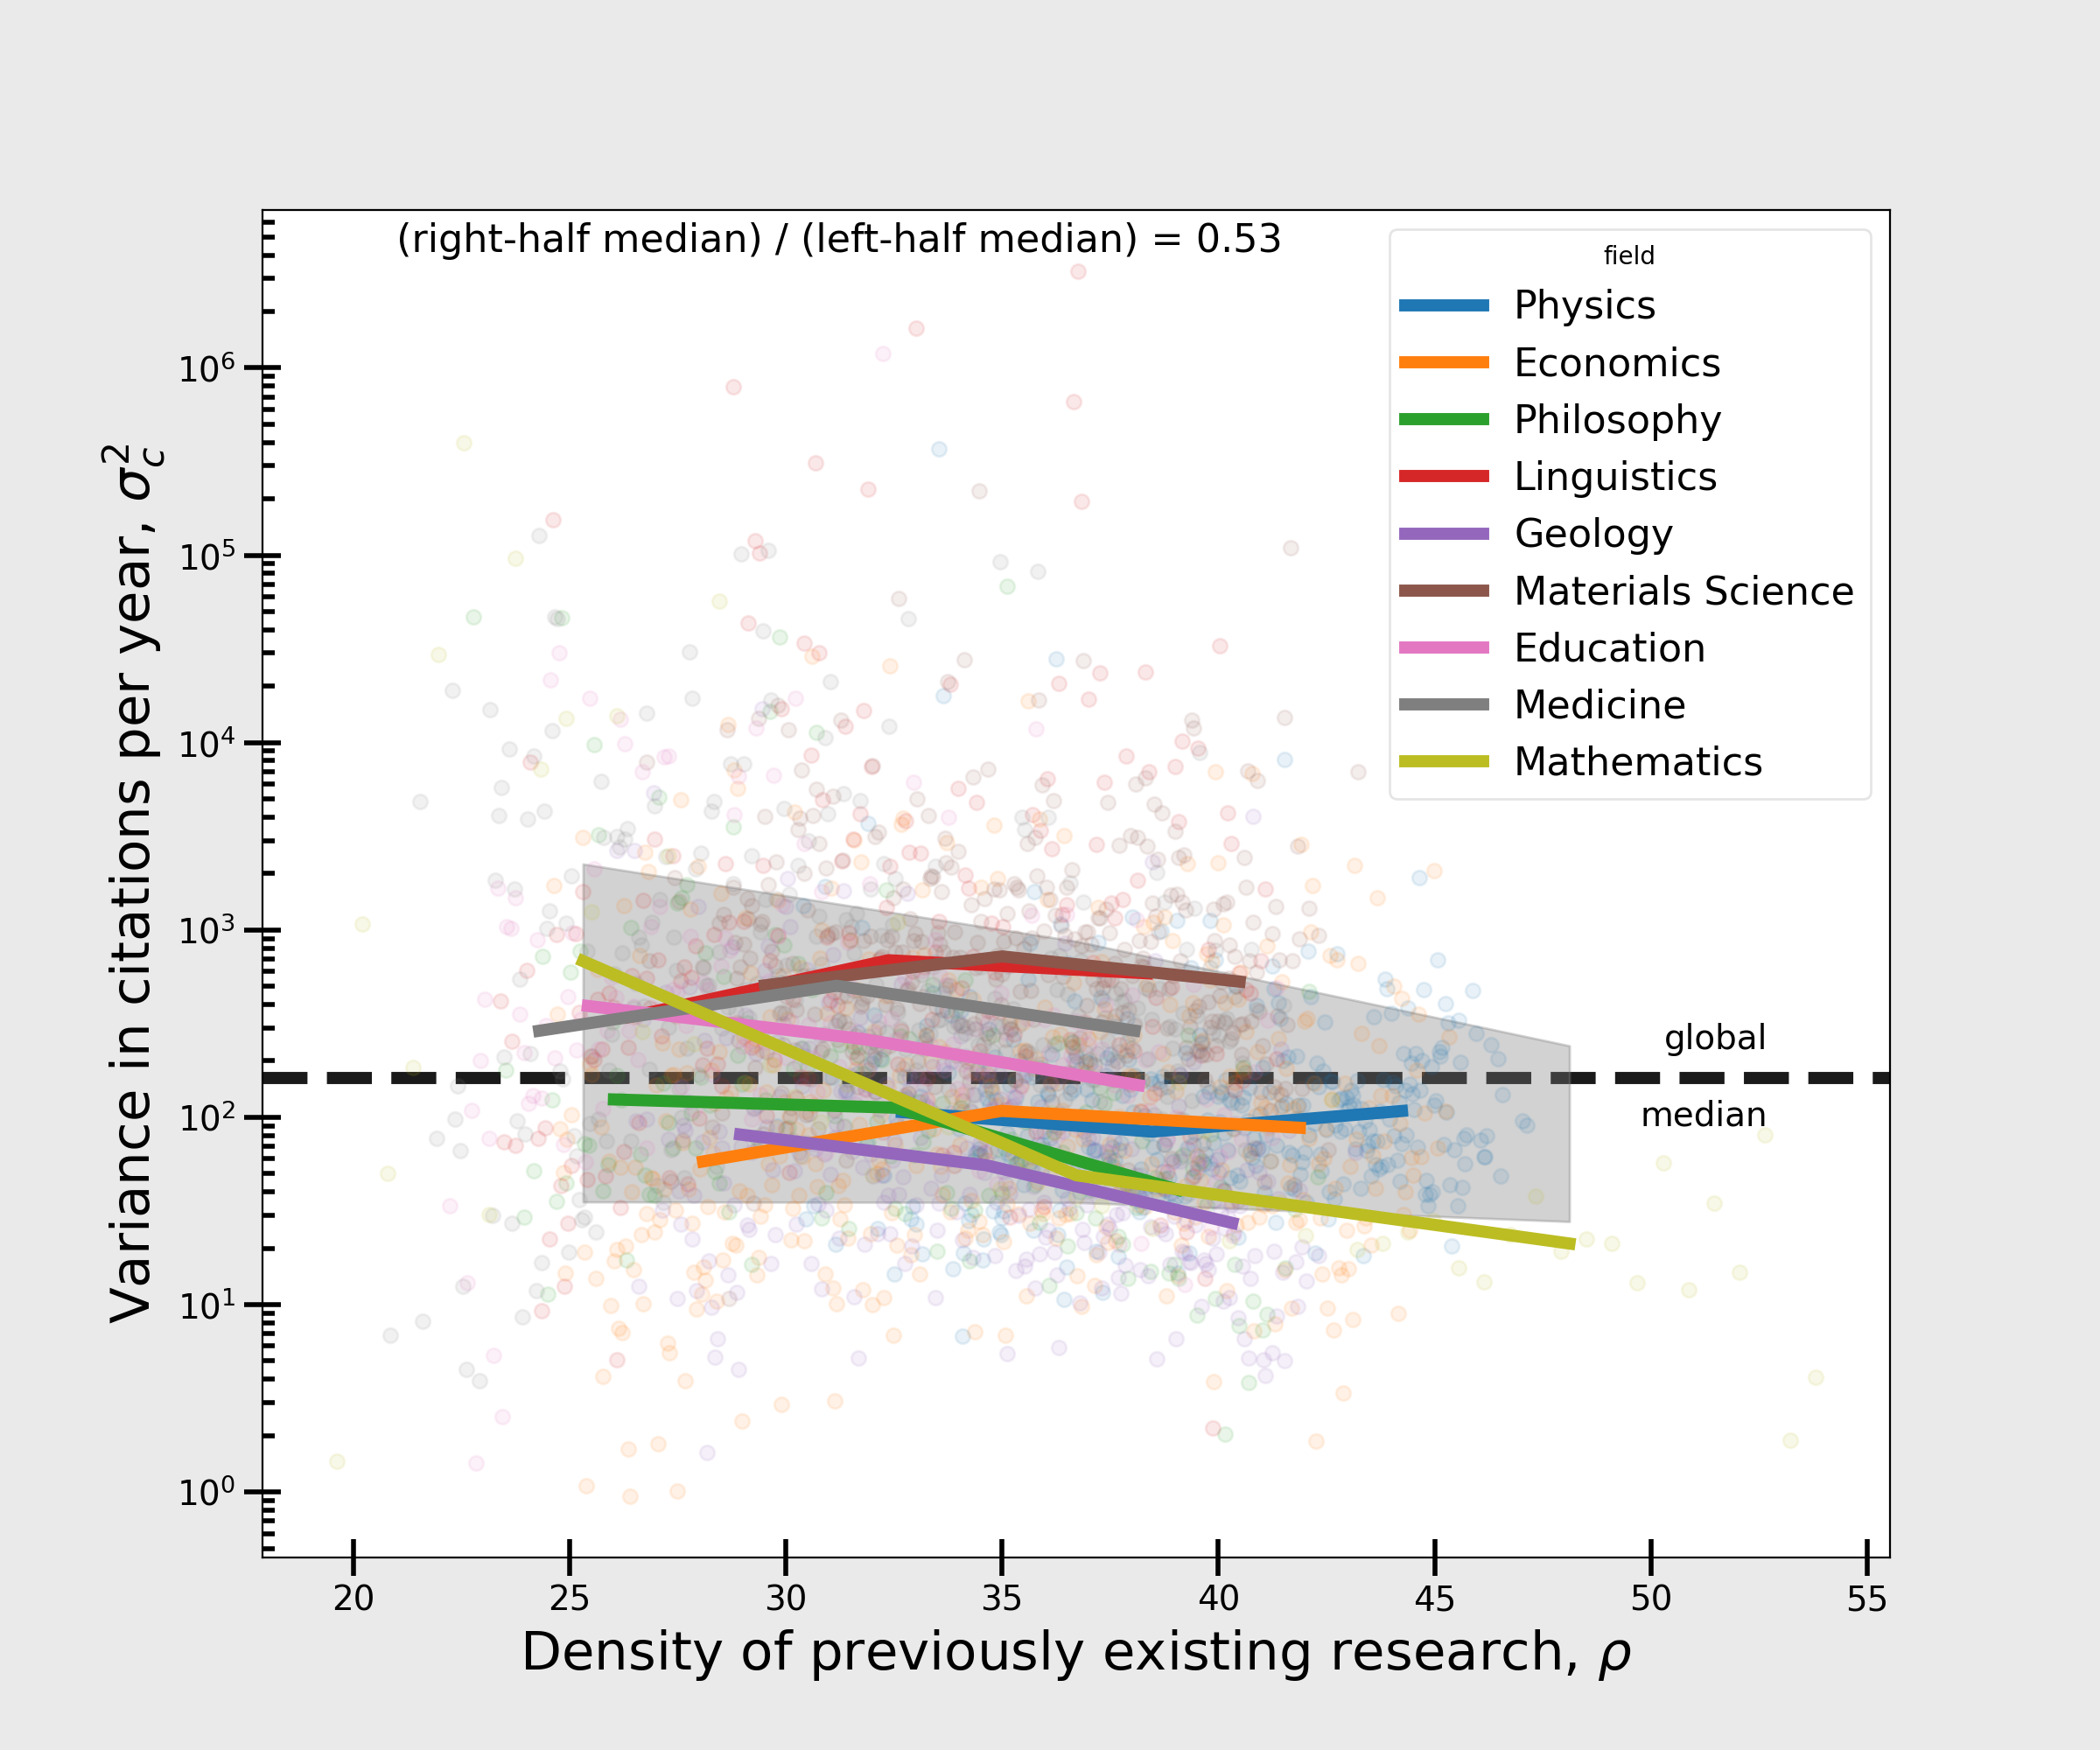

In [666]:
facecolor = np.array([ 235, 235, 235 ]) / 256.
fig = plt.figure( figsize=(12, 5*2), facecolor = facecolor )
ax = plt.gca()


e_n = df_ent_new["density_bin"]

mult = 1.

cpy_v = df_ent_new["cpy_var"]
# ax.scatter(
#     mult * e_n,
#     cpy_v,
#     color = 'k',
#     alpha = 0.1,
# )

# Setup bins

bin_edges = np.linspace(
    e_n.min(),
    e_n.max(),
    # np.nanmean( e_n ) - 2.*np.nanstd( e_n ),
    # np.nanmean( e_n ) + 2.*np.nanstd( e_n ),
    4,
)

xs = bin_edges[:-1] + 0.5 * ( bin_edges[1] - bin_edges[0] )

# Binned median
# binned_median_color = cmap[k]
median, bin_edges, _ = scipy.stats.binned_statistic( e_n, cpy_v, 'median', bins=bin_edges )
upper_fn = lambda y: np.nanpercentile( y, 84 )
upper, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, upper_fn, bins=bin_edges )
lower_fn = lambda y: np.nanpercentile( y, 16 )
lower, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, lower_fn, bins=bin_edges )
ax.fill_between(
    mult * xs,
    lower,
    upper,
    color = "gray",
    alpha = 0.35,
)
# ax.plot(
#     mult * xs,
#     median,
#     linewidth = 10,
#     color = "black",
# )

# Global median number of citations (baseline)
global_median = np.nanpercentile( cpy_v, 50. )
ax.axhline(
    global_median,
    color = '0.1',
    linestyle = '--',
    linewidth = 5,
    zorder = -100,
)
ax.annotate(
    text = 'global\n\nmedian',
    xy = (bin_edges[-1], global_median),
    xycoords = 'data',
    xytext = (-20, 0),
    textcoords = 'offset points',
    va = 'center',
    ha = 'right',
    fontsize = 14,
)

# Summary statistics  
top_half = e_n > np.nanmean( e_n )
cpy_top = cpy_v[top_half]
cpy_bottom = cpy_v[np.invert(top_half)]
cpy_mult = np.nanmedian( cpy_top ) / np.nanmedian( cpy_bottom )
frac_below = ( cpy_top < global_median ).sum() / cpy_top.size
s = (
    r' (right-half median) / (left-half median) =' +
    ' {:.2g}'.format( cpy_mult ) #+
)
values = ax.annotate(
    text = s,
    xy = (1, 1),
    xycoords = 'axes fraction',
    xytext = (-250, -5),
    textcoords = 'offset points',
    va = 'top',
    ha = 'right',
    fontsize = 16,
)

# add fields
fields = df_ent_new.field.unique()
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

for i, field in enumerate(fields):

    df_field = df_ent_new[df_ent_new["field"] == field]

    e_n = df_field["density_bin"]

    cpy_v = df_field["cpy_var"]

    bin_edges = np.linspace(
        e_n.min(),
        e_n.max(),
        # np.nanmean( e_n ) - 2.*np.nanstd( e_n ),
        # np.nanmean( e_n ) + 2.*np.nanstd( e_n ),
        4,
    )

    xs = bin_edges[:-1] + 0.5 * ( bin_edges[1] - bin_edges[0] )

    # Binned median
    # binned_median_color = cmap[k]
    median, bin_edges, _ = scipy.stats.binned_statistic( e_n, cpy_v, 'median', bins=bin_edges )
    upper_fn = lambda y: np.nanpercentile( y, 84 )
    upper, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, upper_fn, bins=bin_edges )
    lower_fn = lambda y: np.nanpercentile( y, 16 )
    lower, _, _ = scipy.stats.binned_statistic( e_n, cpy_v, lower_fn, bins=bin_edges )

    ax.scatter(
        mult * e_n,
        cpy_v,
        alpha = 0.1,
        # label=field,
    )    

    ax.plot(
        mult * xs,
        median,
        linewidth = 5,
        label = field,
    )


ax.legend(
    prop = {'size': 16, },
    ncol = 1,
    loc = 'upper right',
    title = 'field',
    # facecolor = facecolor, 
    # edgecolor = 'white',
    framealpha = 0.5,
)

ax.set_yscale( 'log' )
# from matplotlib.ticker import ScalarFormatter
# ax.yaxis.set_major_formatter(ScalarFormatter())
# ax.yaxis.get_major_formatter().set_scientific(False)

# ax.set_ylim(0,10)
# ax.set_ylim(0.1,0.8)
# ax.set_xlim(25,50)
# ax.set_ylim(0.1,100)

# Axis labels
ax.set_ylabel( r'Variance in citations per year, $\sigma_{c}^2$', fontsize=22 )
# ax.set_ylabel( r'Median citations per year, $c_{cpy}$', fontsize=22 )

ax.set_xlabel( r'Density of previously existing research, $\rho$', fontsize=22 )


# Customize ticks
ax.tick_params( direction='inout', size=15, width=2, labelsize=14 )
ax.tick_params( which='minor', direction='in', size=5, width=2, )

plt.show()

Can we make double figure like og ads paper?

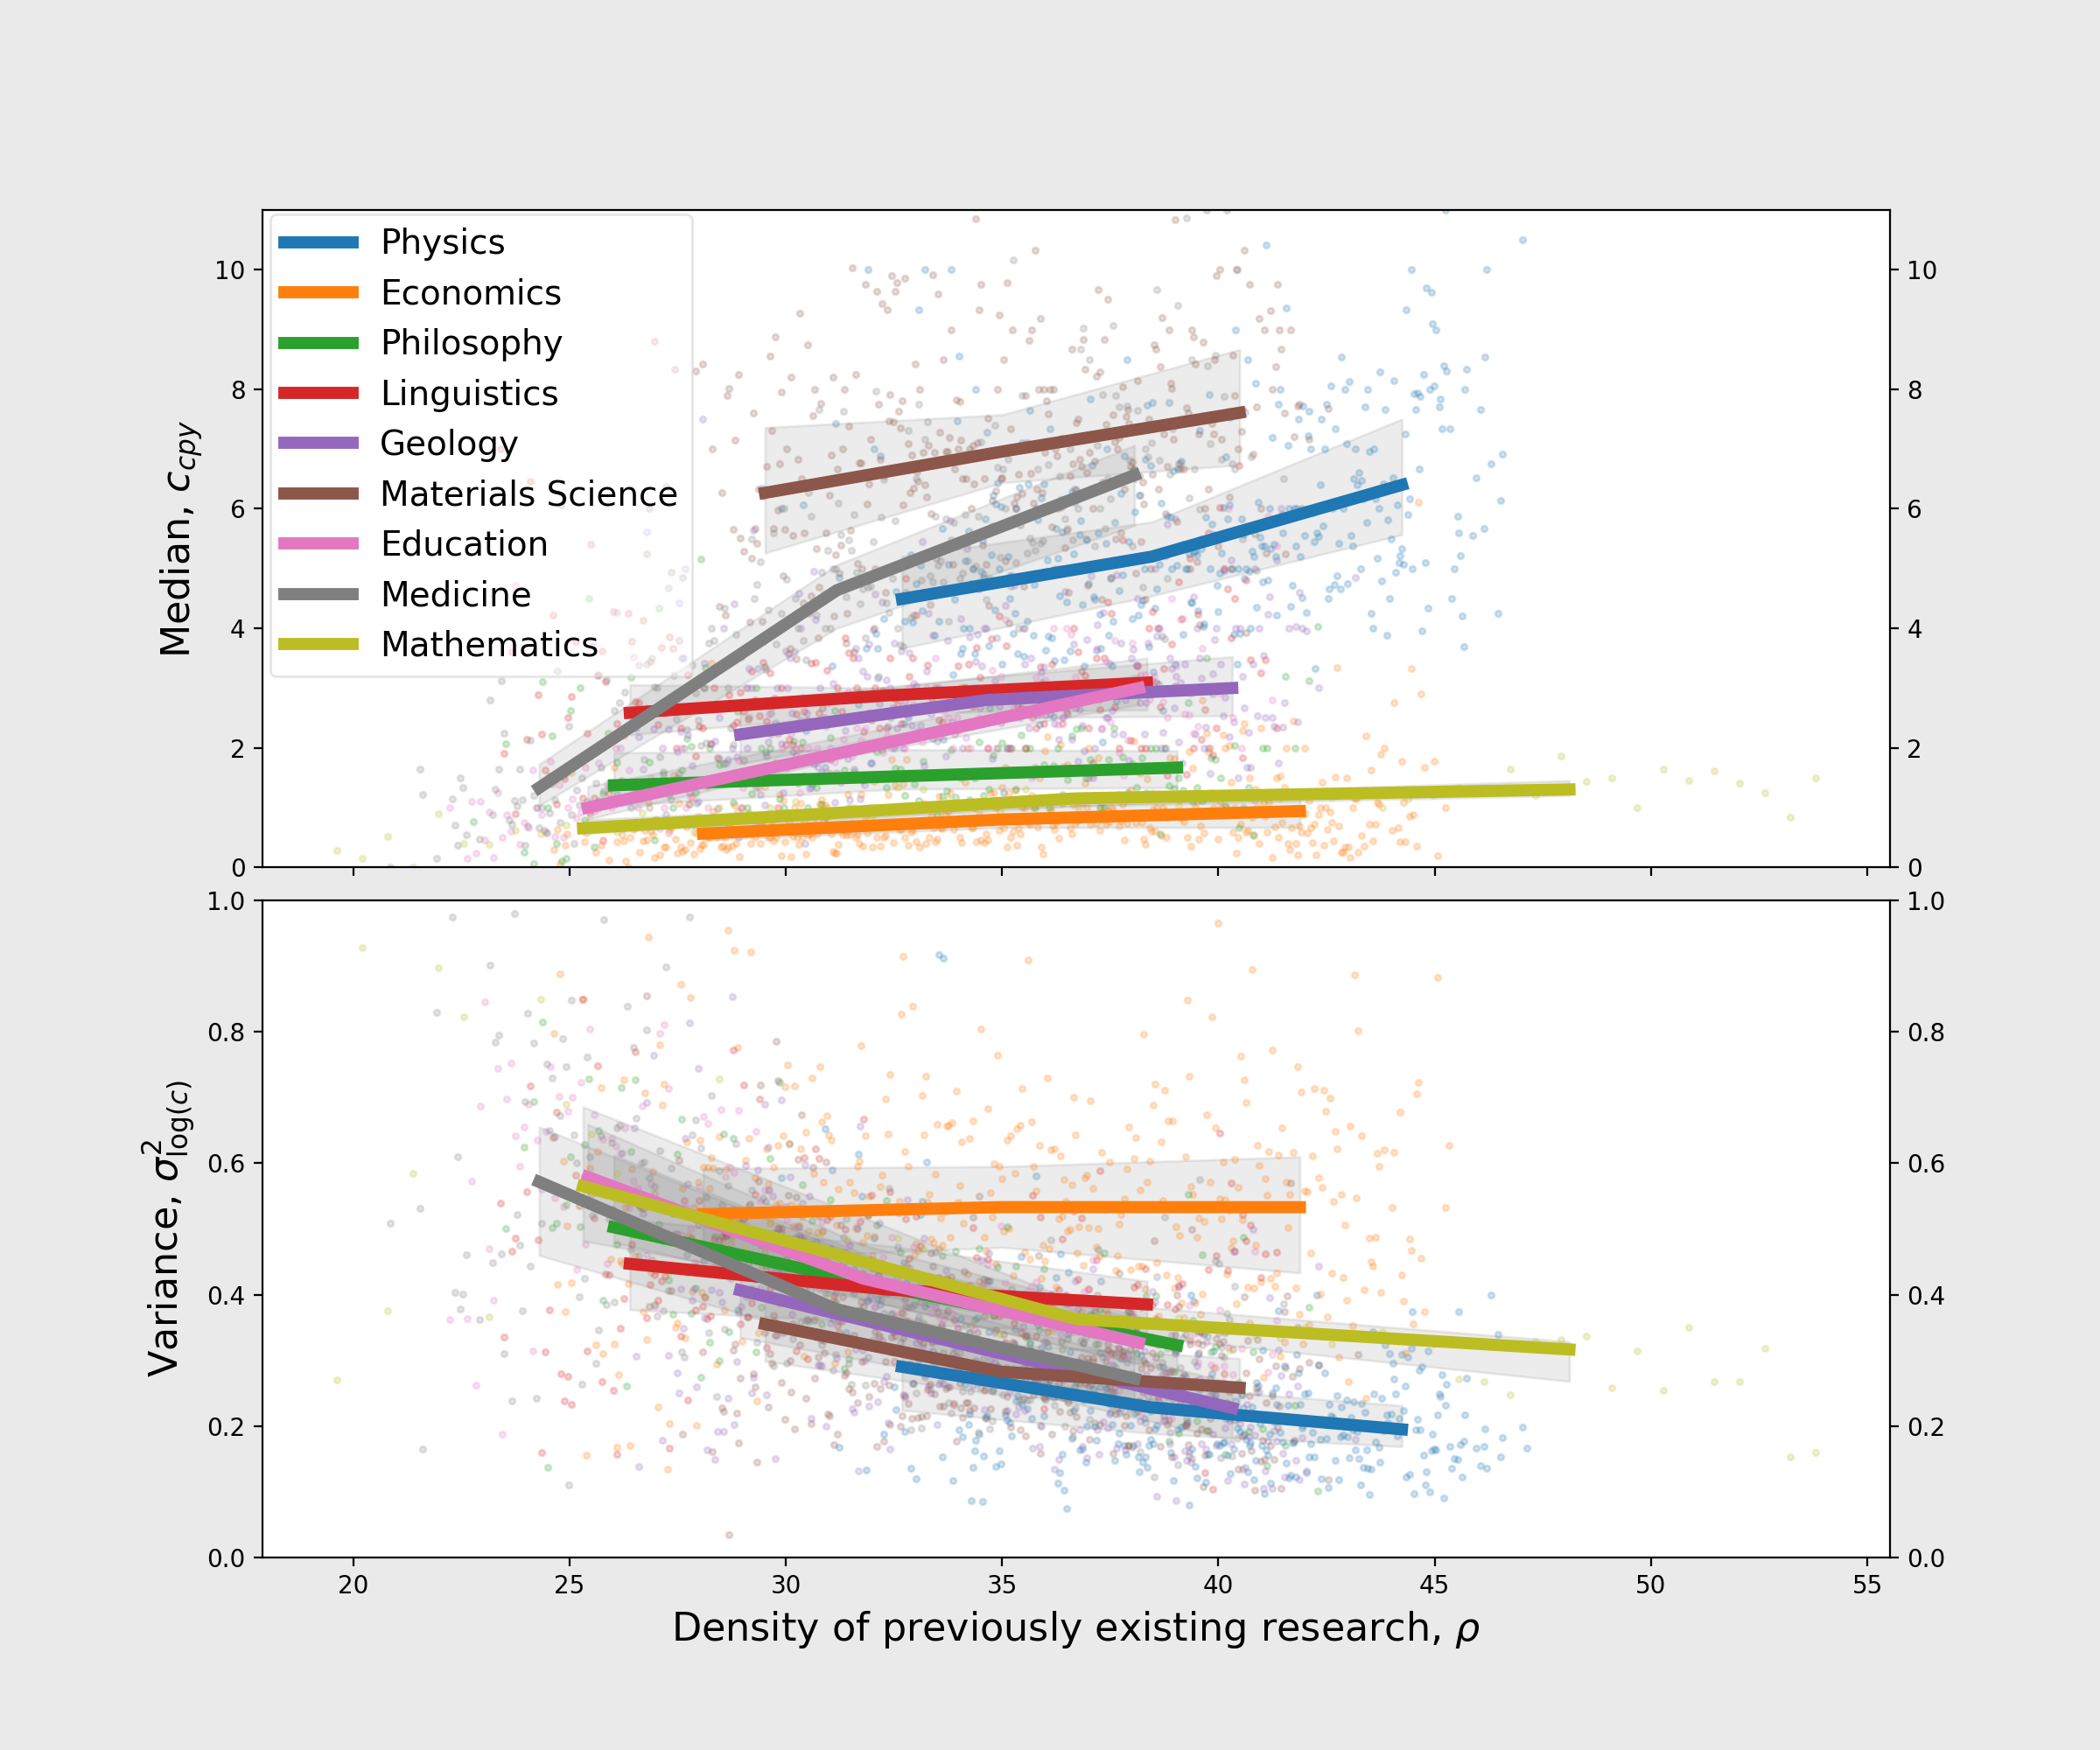

In [731]:
import warnings
import matplotlib.gridspec as gridspec


df_plot = df_ent_new

# df_plot = pd.concat(
#     [get_df_var(df, field, n_bin=20)
#     for field in df["fields_of_study_0"].unique()],
# )


rows = ["median", "variance"]
n_rows = 2

fig = plt.figure( figsize=(12, 5*n_rows), facecolor=facecolor )
# ax = plt.gca()

gs = gridspec.GridSpec( n_rows, 1 )
gs.update( hspace=0.05, wspace=0.001 )


x_variable = "density_bin"
# x_variable = "density_med_bin"
y_variable_maps = {
    "median": "cpy_med",
    "variance": "log_cpy_var",
}

# For each trend
for row_idx, row in enumerate(rows):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax = plt.subplot( gs[row_idx,0],  )

    y_variable = y_variable_maps[row]
    x_observations = df_plot[x_variable]
    y_observations = df_plot[y_variable]

    # N.B.: global scatter, median, percentiles not really well formed across fields, since citation rates are field specific.

    #######################################
    # Fields
    #######################################      

    fields = df_ent_new.field.unique()
    cmap = plt.cm.jet  # define the colormap
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]

    for i, field in enumerate(fields):

        df_field = df_plot[df_plot["field"] == field]

        x_observations_field = df_field[x_variable]
        y_observations_field = df_field[y_variable]

        bin_edges = np.linspace(
            x_observations_field.min(),
            x_observations_field.max(),
            4,
        )

        xs = bin_edges[:-1] + 0.5 * ( bin_edges[1] - bin_edges[0] )

        # Binned median
        median, bin_edges, _ = scipy.stats.binned_statistic( x_observations_field, y_observations_field, 'median', bins=bin_edges )
        upper_fn = lambda y: np.nanpercentile( y, 68 )
        upper, _, _ = scipy.stats.binned_statistic( x_observations_field, y_observations_field, upper_fn, bins=bin_edges )
        lower_fn = lambda y: np.nanpercentile( y, 32 )
        lower, _, _ = scipy.stats.binned_statistic( x_observations_field, y_observations_field, lower_fn, bins=bin_edges )
        ax.fill_between(
            mult * xs,
            lower,
            upper,
            color = "gray",
            alpha = 0.15,
        )

        ax.scatter(
            mult * x_observations_field,
            y_observations_field,
            alpha = 0.2,
            s=6,
            # label=field,
        )    

        ax.plot(
            mult * xs,
            median,
            linewidth = 5,
            label = field,
        )

    #######################################
    # Label rows
    #######################################      
    if row == "median":
        # ax.set_yscale( 'log' )
        # from matplotlib.ticker import ScalarFormatter
        # ax.yaxis.set_major_formatter(ScalarFormatter())
        # ax.yaxis.get_major_formatter().set_scientific(False)                
        ax.set_ylim(0,11)
        ax.set_ylabel( r'Median, $c_{cpy}$', fontsize=16 )

        # Customize ticks
        # ax.tick_params( direction='inout', size=15, width=2, labelsize=14 )
        # ax.tick_params( which='minor', direction='in', size=0, width=2, )


    if row == "variance":
        # ax.set_yscale( 'log' )
        # ax.set_ylim(10,1e4)
        ax.set_ylim(0,1.,)
        # from matplotlib.ticker import ScalarFormatter
        # ax.yaxis.set_major_formatter(ScalarFormatter())
        # ax.yaxis.get_major_formatter().set_scientific(False)        

        ax.set_ylabel( r'Variance, $\sigma_{\log(c)}^2$', fontsize=16 )

    # Customize ticks
    # ax.tick_params( direction='inout', size=15, width=2, labelsize=14 )
    # ax.tick_params( which='minor', direction='in', size=5, width=2, )
    ax.tick_params( right=True, labelright=True )
    if not ax.get_subplotspec().is_last_row():
        ax.tick_params( axis='x', labelbottom=False )

axbox = ax.get_position()
ax.legend(
    prop = {'size': 14, },
    ncol = 1,
    # loc = 'upper right',
    loc = (axbox.x0 + -0.12, axbox.y0 + 1.23),
    # loc = (axbox.x0 + 0.62, axbox.y0 + 0.2),
    # title = 'field',
    # facecolor = facecolor, 
    # edgecolor = 'white',
    framealpha = 0.5,
)


ax.set_xlabel( r'Density of previously existing research, $\rho$', fontsize=16 )

# plt.tight_layout()

plt.show()


Now, a figure illustrating robustness across fields. 
Start by z-scaling all data within each field and then combining.

In [736]:
df

density  edginess  references  citations_per_year  is_center  \
0       38.076275  0.721620          88           61.625000      False   
1       41.553209  0.708944          69            8.200000      False   
2       30.062907  0.686039         179            0.000000      False   
3       39.494263  0.681023          55            3.000000      False   
4       43.866830  0.697031          78           13.888889      False   
...           ...       ...         ...                 ...        ...   
106150  48.730838  0.658585          41            3.500000      False   
106151  25.107589  0.721374          38            3.200000      False   
106152  41.647954  0.646499          11            1.529412      False   
106153  35.738649  0.708053          15            2.384615      False   
106154  31.749805  0.670620           7            0.000000      False   

                                      identifier  year librarian vectorizer  \
0       1d4e43c1be145f6711ec00af900a8658d82623a0  2012        S2    SciBERT   
1       16e772e28b3470cb0050328c6e5a500882ff15ae  2015        S2    SciBERT   
2       0bc5bf8a556f158b1bdaada28ce9cbd28c5d55a4  2017        S2    SciBERT   
3       35d7b77f2a6436124346d80aabc4bd66d5e0bd8b  2017        S2    SciBERT   
4       3dddd8f2734680c584e7a60069e38e58a68d54e6  2011        S2    SciBERT   
...                                          ...   ...       ...        ...   
106150  806f77ba7bdf8a3b80cb859fb5f33f57c1d85d24  2018        S2    SciBERT   
106151  f40707d1165c22e185c25e6837977177ee380f2c  2015        S2    SciBERT   
106152  10636ee16779a7521001651164acb5c192d4ad7b  2003        S2    SciBERT   
106153  a229f829e0a5362d00e63781f687f40ede991635  2007        S2    SciBERT   
106154  8f7f47c0acd81752039abad380df57cf39591506  2012        S2    SciBERT   

                                center fields_of_study_0   log_cpy  
0       hafenLowredshiftLymanLimit2017           Physics  1.789757  
1       hafenLowredshiftLymanLimit2017           Physics  0.913814  
2       hafenLowredshiftLymanLimit2017           Physics       NaN  
3       hafenLowredshiftLymanLimit2017           Physics  0.477121  
4       hafenLowredshiftLymanLimit2017           Physics  1.142668  
...                                ...               ...       ...  
106150                       Andre2018       Mathematics  0.544068  
106151                       Andre2018       Mathematics  0.505150  
106152                       Andre2018       Mathematics  0.184524  
106153                       Andre2018       Mathematics  0.377418  
106154                       Andre2018       Mathematics       NaN  

[106155 rows x 12 columns]